In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
#import pymc3 as pm
import scipy as sp
import pyccl as ccl
import os
import utils
from make_data import MakeData
import getdist
from getdist import plots, MCSamples
%matplotlib inline

# Load data

In [2]:
names_planck  = ['H0_gp', 'Omega_m', 's80', 'S80']
labels_planck = [r'H_0', r'\Omega_{\rm{m}}', r'\sigma_{\rm{8}}',  r'\S_{\rm{8}}']

planck1 = np.loadtxt('/home/jaime/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_1.txt')
planck2 = np.loadtxt('/home/jaime/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_2.txt')
planck3 = np.loadtxt('/home/jaime/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_3.txt')
planck4 = np.loadtxt('/home/jaime/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_4.txt')

planck_tot = np.concatenate((planck1, planck2, planck3, planck4), axis=0)

planck_params = []
for item in planck_tot:
    planck_params.append([item[29], item[31], item[34], item[35]])
planck_params = np.array(planck_params)
planck_samples = MCSamples(samples=planck_params, names = names_planck, labels = labels_planck, label= r'$Planck$ 2018',
                    weights=np.transpose(planck_tot)[0],loglikes=np.transpose(planck_tot)[1])

Removed no burn in


In [3]:
z_max = 1110
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaime/PhD/Growz/data/products'

data_class = MakeData(z_max, res , path)
Planck = data_class.Planck
z_planck = data_class.z_planck
c = data_class.c

old_DESI_data = data_class.get_DESI(new=True, mode=None)
DESI_data = data_class.get_synthetic('DESI', new=True)
DESIts_data = data_class.get_synthetic('DESI_ts', new=True)
DESIhs_data = data_class.get_synthetic('DESI_hs', new=True)
DESIfs_data = data_class.get_synthetic('DESI_fs', new=True)
DESI2n_data = data_class.get_synthetic('DESI_2n', new=True)
DESI5n_data = data_class.get_synthetic('DESI_5n', new=True)
DESI10n_data = data_class.get_synthetic('DESI_10n', new=True)
DESI100n_data = data_class.get_synthetic('DESI_100n', new=True)
Euclid_data = data_class.get_synthetic('Euclid', new=True)
WFIRST_data = data_class.get_synthetic('WFIRST', new=True)

CC_data = data_class.get_CC(new=False)
DSS_data = data_class.get_DSS(new=False)
BOSS_data = data_class.get_BOSS(new=False)
eBOSS_data = data_class.get_eBOSS(new=False)
Wigglez_data = data_class.get_Wigglez(new=False)
DS17_data = data_class.get_DS17(new=False)
CMB_data = data_class.get_CMB(new=False)

Using Planck mean
Making new old_DESI
Multiplying error bars by  1
[ 1.3315865   0.71527897 -1.54540029 -0.00838385  0.62133597 -0.72008556
  0.26551159  0.10854853  0.00429143 -0.17460021  0.43302619  1.20303737
 -0.96506567  1.02827408  0.22863013  0.44513761 -1.13660221  0.13513688]
Making new DESI
[ 1.3315865   0.71527897 -1.54540029 -0.00838385  0.62133597 -0.72008556
  0.26551159  0.10854853  0.00429143 -0.17460021  0.43302619  1.20303737
 -0.96506567  1.02827408  0.22863013  0.44513761 -1.13660221  0.13513688]
Making new DESI_ts
[ 1.3315865   0.71527897 -1.54540029 -0.00838385  0.62133597 -0.72008556
  0.26551159  0.10854853  0.00429143 -0.17460021  0.43302619  1.20303737
 -0.96506567  1.02827408  0.22863013  0.44513761 -1.13660221  0.13513688]
Making new DESI_hs
[ 1.3315865   0.71527897 -1.54540029 -0.00838385  0.62133597 -0.72008556
  0.26551159  0.10854853  0.00429143 -0.17460021  0.43302619  1.20303737
 -0.96506567  1.02827408  0.22863013  0.44513761 -1.13660221  0.13513688]

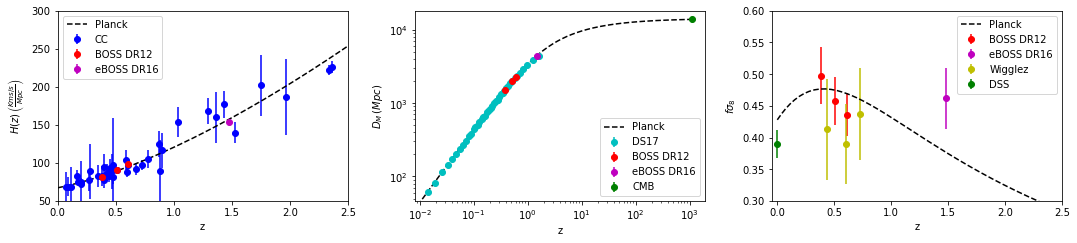

In [4]:
fig=plt.figure(figsize=(18,3.5))
fig.subplots_adjust(wspace=0.23)

ax1 = plt.subplot(131)
plt.plot(z_planck, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='mo', label='eBOSS DR16')
# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

ax1 = plt.subplot(132)
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.4)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='co', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'], 
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='mo', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']), 
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='go', label='CMB')

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.loglog()
plt.ylabel(r"$D_M \, (Mpc)$")
plt.legend();

ax1 = plt.subplot(133)
plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ro', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='mo', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='yo', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='go', label='DSS')

plt.xlim(-0.05, 2.5)
plt.ylim(0.3, 0.6)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf', bbox_inches='tight', pad_inches=0)


In [5]:
np.savez("/home/jaime/PhD/GoFish/fs8.npz", z=z_planck, fs8=Planck['f_arr']*Planck['s8_arr'])

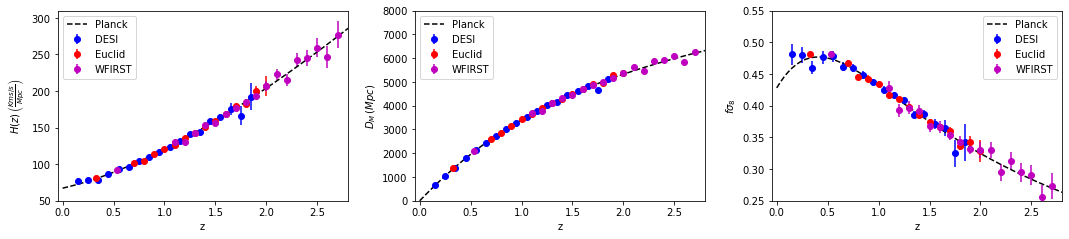

In [6]:
fig=plt.figure(figsize=(18,3.5))
fig.subplots_adjust(wspace=0.23)

ax1 = plt.subplot(131)
plt.plot(z_planck, Planck['Hkms_arr'], "k--", label='Planck')
plt.errorbar(DESI_data['z'], DESI_data['H_data'], yerr = DESI_data['H_err'], fmt='bo', label='DESI')
plt.errorbar(Euclid_data['z'], Euclid_data['H_data'], yerr=Euclid_data['H_err'], fmt='ro', label='Euclid')
plt.errorbar(WFIRST_data['z'], WFIRST_data['H_data'], yerr=WFIRST_data['H_err'], fmt='mo', label='WFIRST')
# axis labels and title
plt.xlim(-0.05, 2.8)
plt.ylim(50, 310)
plt.xlabel("z")
plt.ylabel(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

ax1 = plt.subplot(132)
plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DESI_data['z'], (1+DESI_data['z'])*DESI_data['dA_data'], yerr = DESI_data['dA_err'], fmt='bo', label='DESI')
plt.errorbar(Euclid_data['z'], (1+Euclid_data['z'])*Euclid_data['dA_data'], yerr=Euclid_data['dA_err'], fmt='ro', label='Euclid')
plt.errorbar(WFIRST_data['z'], (1+WFIRST_data['z'])*WFIRST_data['dA_data'], yerr=WFIRST_data['dA_err'], fmt='mo', label='WFIRST')

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.xlim(-0.05, 2.8)
plt.ylim(-0.05, 8000)
plt.ylabel(r"$D_M \, (Mpc)$")
plt.legend();

ax1 = plt.subplot(133)
plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(DESI_data['z'], DESI_data['fs8_data'], yerr = DESI_data['fs8_err'], fmt='bo', label='DESI')
plt.errorbar(Euclid_data['z'], Euclid_data['fs8_data'], yerr=Euclid_data['fs8_err'], fmt='ro', label='Euclid')
plt.errorbar(WFIRST_data['z'], WFIRST_data['fs8_data'], yerr=WFIRST_data['fs8_err'], fmt='mo', label='WFIRST')

plt.xlim(-0.05, 2.8)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf', bbox_inches='tight', pad_inches=0)


In [7]:
Hmean = [data_class.cosmo.Hubble(z)*data_class.c/1000 for z in DESI_data['z']]
HHmean = [data_class.cosmo.Hubble(z)*data_class.c/1000 for z in old_DESI_data['z']]
Dmean = [data_class.cosmo.angular_distance(z) for z in DESI_data['z']]
DDmean = [data_class.cosmo.angular_distance(z) for z in old_DESI_data['z']]
fs8mean = [data_class.cosmo.scale_independent_growth_factor_f(z)*data_class.cosmo.sigma(8./data_class.cosmo.h(),z) for z in DESI_data['z']]
ffs8mean = [data_class.cosmo.scale_independent_growth_factor_f(z)*data_class.cosmo.sigma(8./data_class.cosmo.h(),z) for z in old_DESI_data['z']]

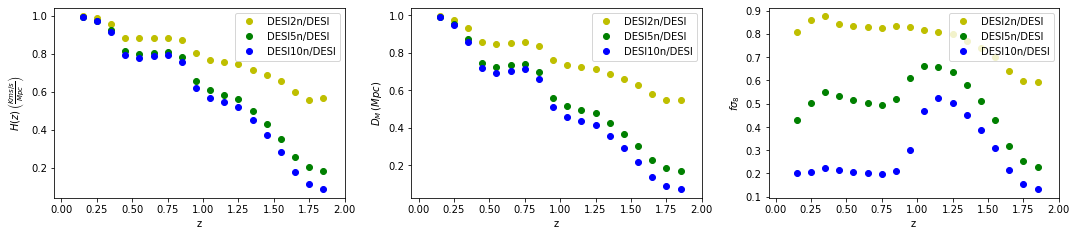

In [8]:
fig=plt.figure(figsize=(18,3.5))
fig.subplots_adjust(wspace=0.23)

ax1 = plt.subplot(131)
plt.plot(DESI_data['z'], DESI2n_data['H_err']/DESI_data['H_err'], 'yo', label='DESI2n/DESI')
plt.plot(DESI_data['z'], DESI5n_data['H_err']/DESI_data['H_err'], 'go', label='DESI5n/DESI')
plt.plot(DESI_data['z'], DESI10n_data['H_err']/DESI_data['H_err'], 'bo', label='DESI10n/DESI')
#plt.plot(DESI_data['z'], DESI100n_data['H_err']/DESI_data['H_err'], 'ro', label='DESI100n/DESI')
# axis labels and title
plt.xlim(-0.05, 2.)
plt.xlabel("z")
plt.ylabel(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

ax1 = plt.subplot(132)
#plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.plot(DESI_data['z'], DESI2n_data['dA_err']/DESI_data['dA_err'], 'yo', label='DESI2n/DESI')
plt.plot(DESI_data['z'], DESI5n_data['dA_err']/DESI_data['dA_err'], 'go', label='DESI5n/DESI')
plt.plot(DESI_data['z'], DESI10n_data['dA_err']/DESI_data['dA_err'], 'bo', label='DESI10n/DESI')
#plt.plot(DESI_data['z'], DESI100n_data['dA_err']/DESI_data['dA_err'], 'ro', label='DESI100n/DESI')
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.xlim(-0.05, 2)
plt.ylabel(r"$D_M \, (Mpc)$")
plt.legend();

ax1 = plt.subplot(133)
#plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.plot(DESI_data['z'], DESI2n_data['fs8_err']/DESI_data['fs8_err'], 'yo', label='DESI2n/DESI')
plt.plot(DESI_data['z'], DESI5n_data['fs8_err']/DESI_data['fs8_err'], 'go', label='DESI5n/DESI')
plt.plot(DESI_data['z'], DESI10n_data['fs8_err']/DESI_data['fs8_err'], 'bo', label='DESI10n/DESI')
#plt.plot(DESI_data['z'], DESI100n_data['fs8_err']/DESI_data['fs8_err'], 'ro', label='DESI100n/DESI')
plt.xlim(-0.05, 2)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf', bbox_inches='tight', pad_inches=0)


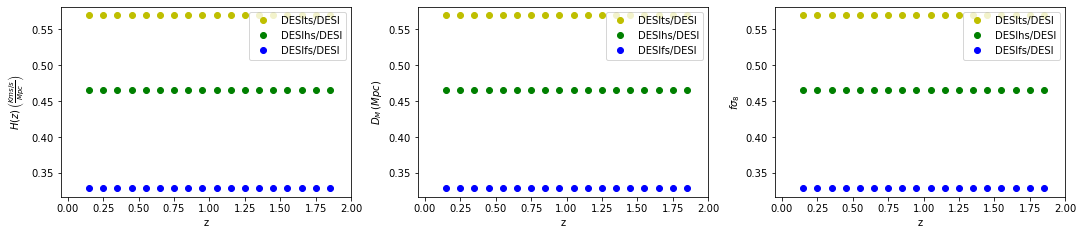

In [9]:
fig=plt.figure(figsize=(18,3.5))
fig.subplots_adjust(wspace=0.23)

ax1 = plt.subplot(131)
plt.plot(DESI_data['z'], DESIts_data['H_err']/DESI_data['H_err'], 'yo', label='DESIts/DESI')
plt.plot(DESI_data['z'], DESIhs_data['H_err']/DESI_data['H_err'], 'go', label='DESIhs/DESI')
plt.plot(DESI_data['z'], DESIfs_data['H_err']/DESI_data['H_err'], 'bo', label='DESIfs/DESI')
#plt.plot(DESI_data['z'], DESI100n_data['H_err']/DESI_data['H_err'], 'ro', label='DESI100n/DESI')
# axis labels and title
plt.xlim(-0.05, 2.)
plt.xlabel("z")
plt.ylabel(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

ax1 = plt.subplot(132)
#plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.plot(DESI_data['z'], DESIts_data['dA_err']/DESI_data['dA_err'], 'yo', label='DESIts/DESI')
plt.plot(DESI_data['z'], DESIhs_data['dA_err']/DESI_data['dA_err'], 'go', label='DESIhs/DESI')
plt.plot(DESI_data['z'], DESIfs_data['dA_err']/DESI_data['dA_err'], 'bo', label='DESIfs/DESI')
#plt.plot(DESI_data['z'], DESI100n_data['dA_err']/DESI_data['dA_err'], 'ro', label='DESI100n/DESI')
plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.xlim(-0.05, 2)
plt.ylabel(r"$D_M \, (Mpc)$")
plt.legend();

ax1 = plt.subplot(133)
#plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.plot(DESI_data['z'], DESIts_data['fs8_err']/DESI_data['fs8_err'], 'yo', label='DESIts/DESI')
plt.plot(DESI_data['z'], DESIhs_data['fs8_err']/DESI_data['fs8_err'], 'go', label='DESIhs/DESI')
plt.plot(DESI_data['z'], DESIfs_data['fs8_err']/DESI_data['fs8_err'], 'bo', label='DESIfs/DESI')
#plt.plot(DESI_data['z'], DESI100n_data['fs8_err']/DESI_data['fs8_err'], 'ro', label='DESI100n/DESI')
plt.xlim(-0.05, 2)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf', bbox_inches='tight', pad_inches=0)


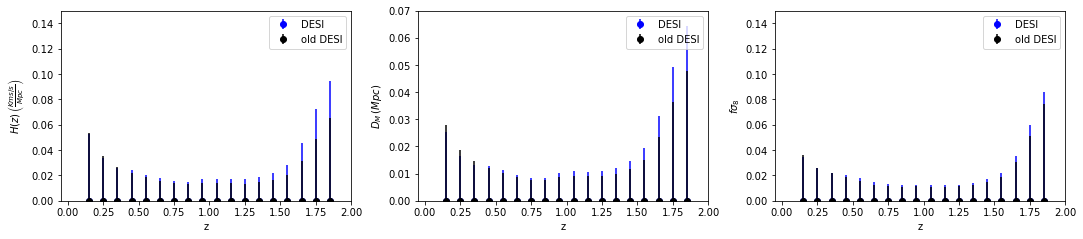

In [10]:
fig=plt.figure(figsize=(18,3.5))
fig.subplots_adjust(wspace=0.23)

ax1 = plt.subplot(131)
plt.errorbar(DESI_data['z'], np.zeros_like(DESI_data['H_data']-Hmean)/Hmean, yerr = DESI_data['H_err']/Hmean, fmt='bo', label='DESI')
plt.errorbar(old_DESI_data['z'], np.zeros_like(old_DESI_data['H_data']), yerr = old_DESI_data['H_err']/HHmean, fmt='ko', label='old DESI')

# axis labels and title
plt.xlim(-0.05, 2.)
plt.ylim(0, 0.15)
plt.xlabel("z")
plt.ylabel(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

ax1 = plt.subplot(132)
#plt.plot(z_planck, Planck['dM_arr'], "k--", label='Planck')
plt.errorbar(DESI_data['z'], np.zeros_like(DESI_data['dA_data']-Dmean)/Dmean, yerr = DESI_data['dA_err']/Dmean, fmt='bo', label='DESI')
plt.errorbar(old_DESI_data['z'], np.zeros_like(old_DESI_data['dA_data']), yerr = old_DESI_data['dA_err']/DDmean, fmt='ko', label='old DESI')


plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.xlim(-0.05, 2)
plt.ylim(0, 0.07)
plt.ylabel(r"$D_M \, (Mpc)$")
plt.legend();

ax1 = plt.subplot(133)
#plt.plot(z_planck, Planck['f_arr']*Planck['s8_arr'], "k--", label='Planck')
plt.errorbar(DESI_data['z'], np.zeros_like(DESI_data['fs8_data']-fs8mean)/fs8mean, yerr = DESI_data['fs8_err']/fs8mean, fmt='bo', label='DESI')
plt.errorbar(old_DESI_data['z'], np.zeros_like(old_DESI_data['fs8_data']), yerr = old_DESI_data['fs8_err']/ffs8mean, fmt='ko', label='old DESI')

plt.xlim(-0.05, 2)
plt.ylim(0., .15)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/data.pdf', bbox_inches='tight', pad_inches=0)


In [11]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [12]:
path = '/home/jaime/PhD/Growz/data/outputs/DESI_LCDM/'
DESI_LCDM = np.load(os.path.join(path,'LCDM_DESI_CMB_Planck_1005_1005/samples.npz'))
DESIts_LCDM = np.load(os.path.join(path,'LCDM_DESI_ts_CMB_Planck_1000_1000/samples.npz'))
DESIhs_LCDM = np.load(os.path.join(path,'LCDM_DESI_hs_CMB_Planck_1005_1005/samples.npz'))
DESIfs_LCDM = np.load(os.path.join(path,'LCDM_DESI_fs_CMB_Planck_1005_1005/samples.npz'))
DESI2n_LCDM = np.load(os.path.join(path,'LCDM_DESI_2n_CMB_Planck_1000_1000/samples.npz'))
DESI5n_LCDM = np.load(os.path.join(path,'LCDM_DESI_5n_CMB_Planck_1000_1000/samples.npz'))
DESI10n_LCDM = np.load(os.path.join(path,'LCDM_DESI_10n_CMB_Planck_1005_1005/samples.npz'))

path = '/home/jaime/PhD/Growz/data/outputs/LCDM/'
fiducial_LCDM = np.load(os.path.join(path,'LCDM_All_CMB_Planck_10000_10000/samples.npz'))
old_DESI_LCDM = np.load(os.path.join(path,'LCDM_DESI_CMB_Planck_1003_1003/samples.npz'))
Euclid_LCDM = np.load(os.path.join(path,'LCDM_Euclid_CMB_Planck_1002_1002/samples.npz'))
WFIRST_LCDM = np.load(os.path.join(path,'LCDM_WFIRST_CMB_Planck_1002_1002/samples.npz'))
path = '/home/jaime/PhD/Growz/data/outputs/finals'
H = np.load(os.path.join(path, 'All_CMB_Planck_95_2500_2500/samples.npz'))

path = '/home/jaime/PhD/Growz/data/outputs/Xi/'
path_hp = '/home/jaime/PhD/Growz/data/outputs/Xi_fixed_hp/'
Xi_P18 = np.load(os.path.join(path,'All_gro_best_fit_Xi_P18_full_3000_7000/samples.npz'))
Xi_P18_hp = np.load(os.path.join(path_hp,'All_gro_Xi_P18_full_3000_3000/samples.npz'))
Xi_P18_widehp = np.load(os.path.join(path_hp,'All_gro_Xi_P18_full_widehp_3000_3000/samples.npz'))
Xi_LCDM = np.load(os.path.join(path,'All_CMB_Planck_Xi_LCDM_3000_7000/samples.npz'))
Xi_wCDM = np.load(os.path.join(path,'All_CMB_Planck_Xi_wCDM_3500_7000/samples.npz'))
HXi = np.load(os.path.join(path,'All_CMB_Planck_Xi_H_3000_7000/samples.npz'))
HXi_hp = np.load(os.path.join(path,'All_CMB_Xi_H_fixed_n_l_3000_3000/samples.npz'))
HXi_n = np.load(os.path.join(path_hp,'All_CMB_Planck_Xi_H_fixed_n_noWm_3000_3000/samples.npz'))
HXi_widehp = np.load(os.path.join(path_hp,'All_CMB_Planck_Xi_H_wide_n_l_4000_4000/samples.npz'))
HXi_widerhp = np.load(os.path.join(path_hp,'All_CMB_Planck_Xi_H_wider_hp_3000_3000/samples.npz'))
HXi_noWm = np.load(os.path.join(path_hp,'All_CMB_Planck_Xi_H_fixed_hp_noWm_3000_3000/samples.npz'))
Euclid_HXi = np.load(os.path.join(path,'Euclid_CMB_Planck_Xi_H_3000_7000/samples.npz'))
DESI_HXi = np.load(os.path.join(path,'DESI_CMB_Planck_Xi_H_3000_7000/samples.npz'))
DESI_HXi_hp = np.load(os.path.join(path, 'DESI_CMB_Xi_H_fixed_n_l_3000_3000/samples.npz'))
DESI_HXi_n = np.load(os.path.join(path_hp, 'DESI_CMB_Planck_Xi_H_fixed_n_noWm_3000_3000/samples.npz'))
DESI_HXi_widehp = np.load(os.path.join(path_hp, 'DESI_CMB_Planck_Xi_H_wide_hp_4000_4000/samples.npz'))
DESI_HXi_noWm = np.load(os.path.join(path_hp, 'DESI_CMB_Planck_Xi_H_fixed_hp_noWm_3000_3000/samples.npz'))
DESIts_HXi = np.load(os.path.join(path_hp,'DESI_ts_CMB_Planck_Xi_H_fixed_n_l_4000_4000/samples.npz'))
DESIhs_HXi = np.load(os.path.join(path_hp,'DESI_hs_CMB_Planck_Xi_H_fixed_n_l_4000_4000/samples.npz'))
DESIfs_HXi = np.load(os.path.join(path_hp,'DESI_fs_CMB_Planck_Xi_H_fixed_n_l_4000_4000/samples.npz'))
DESI2n_HXi = np.load(os.path.join(path_hp,'DESI_2n_CMB_Planck_Xi_H_fixed_n_l_4000_4000/samples.npz'))
DESI5n_HXi = np.load(os.path.join(path_hp,'DESI_5n_CMB_Planck_Xi_H_fixed_n_l_4000_4000/samples.npz'))
DESI10n_HXi = np.load(os.path.join(path_hp,'DESI_10n_CMB_Planck_Xi_H_fixed_n_l_4000_4000/samples.npz'))


##Forecast 
#Desi 
#Lsst 

# Triangle Plots

In [20]:
labels_dict = {'n': '\eta_H',
               'l': 'l_H',
               'A0': 'A0',
               'n_H': '\eta_H',
               'l_H': 'l_H',
               'n_Xi': '\eta_{\mu}',
               'l_Xi': 'l_{\mu}',
               'mu_0': '\mu_0',
               'H0': 'H_0',
               'H0_gp': 'H_0',
               'w0': 'w_0',
               'wa': 'w_a',
               'Omega_m': '\Omega_m',
               'Omega_m_mean': '\Omega_m^{mean}',
               's80': '\sigma_8',
               'S80': 'S_8',
               'rd': 'r_s',
               'M': 'M',
               'nh_nmu': '\sqrt{\eta_H^2+\eta_\mu^2}'}
names_All = ['n', 'l', 'n_H', 'l_H', 'n_Xi', 'l_Xi',#
             'H0', 'H0_gp',  'Omega_m', 'Omega_m', 
             'Omega_m_mean', 'w0', 'wa', 's80', 'S80', 'M']
#ranges = {'l':[0.001, 7], 'omega_b': [0.022, 0.023]}
ranges = {'l':[0.001, 7], 'l_Xi':[0.001, 7], 'l_H':[0.001, 7], 'n':[0., 2], 'n_H':[0., 2], 'n_Xi':[0., 2]}

In [21]:
def make_samples(file, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            labels.append(labels_dict[name]) 
            samples.append(file[name])
    if 'Xiz' in file.keys():
        namess.append('mu_0')
        labels.append(labels_dict['mu_0'])
        samples.append(np.transpose(file['Xiz'])[0])
    #if 'n_H' in file.keys():
    #    namess.append('nh_nmu')
    #    labels.append(labels_dict['nh_nmu'])
    #    samples.append(np.sqrt(file['n_H']**2+file['n_Xi']**2))
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3})

In [74]:
LCDM_samples = make_samples(fiducial_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'], ranges, r'$\Lambda$CDM')
DESI_LCDM_samples = make_samples(DESI_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], ranges, r'DESI $\Lambda$CDM')
DESIts_LCDM_samples = make_samples(DESIhs_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], ranges, r'DESI third sky $\Lambda$CDM')
DESIhs_LCDM_samples = make_samples(DESIhs_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], ranges, r'DESI half sky $\Lambda$CDM')
DESIfs_LCDM_samples = make_samples(DESIfs_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], ranges, r'DESI full sky $\Lambda$CDM')
DESI2n_LCDM_samples = make_samples(DESI2n_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], ranges, r'DESI x2 N(z) $\Lambda$CDM')
DESI5n_LCDM_samples = make_samples(DESI5n_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], ranges, r'DESI x5 N(z) $\Lambda$CDM')
DESI10n_LCDM_samples = make_samples(DESI10n_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], ranges, r'DESI x10 N(z) $\Lambda$CDM')

Euclid_LCDM_samples = make_samples(Euclid_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], ranges, r'Euclid $\Lambda$CDM')
WFIRST_LCDM_samples = make_samples(WFIRST_LCDM, ['H0_gp', 'Omega_m', 's80', 'S80'], ranges, r'WFIRST $\Lambda$CDM')
H_samples = make_samples(H, ['A0', 'n_H', 'l_H', 'H0_gp', 'Omega_m', 's80', 'S80'], ranges, '$H_{gp}$')
Xi_P18_samples = make_samples(Xi_P18, ['n_Xi', 'l_Xi',  'mu_0', 'H0_gp', 'Omega_m', 's80', 'S80'],
                          ranges, r'$\mu_{gp}+P18 full$')
Xi_LCDM_samples = make_samples(Xi_LCDM, ['n_Xi', 'l_Xi', 'mu_0', 'H0_gp', 'Omega_m', 'Omega_m_mean', 's80', 'S80', 'rd', 'M'],
                          ranges, r'$\mu_{gp}+\Lambda$CDM')
Xi_wCDM_samples = make_samples(Xi_wCDM, ['n_Xi', 'l_Xi', 'mu_0', 'H0_gp', 'Omega_m', 'Omega_m_mean', 'w0', 'wa', 's80', 'S80', 'rd', 'M'],
                          ranges, r'$\mu_{gp}+w$CDM')
HXi_samples = make_samples(HXi, ['n_H', 'l_H', 'n_Xi', 'l_Xi', #'nh_nmu',
                                 'A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                                ranges, '$H_{gp}+\mu_{gp}$')
HXi_hp_samples = make_samples(HXi_hp, ['A0', 'H0_gp', 'Omega_m', 's80', 'rd', 'M'],
                                ranges, '$H_{gp}+\mu_{gp}$ + Fixed HP')
HXi_n_samples = make_samples(HXi_n, ['l_H', 'l_Xi', 'A0', 'H0_gp', 's80', 'rd', 'M'],
                                ranges, '$H_{gp}+\mu_{gp}$ + no $\Omega_m$ + Fixed n')
HXi_widehp_samples = make_samples(HXi_widehp, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                                ranges, '$H_{gp}+\mu_{gp}$ + Wide HP')
HXi_widerhp_samples = make_samples(HXi_widerhp, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd', 'M'],
                                ranges, '$H_{gp}+\mu_{gp}$ + Wider HP')
DESI_HXi_samples = make_samples(DESI_HXi, ['n_H', 'l_H', 'n_Xi', 'l_Xi', #'nh_nmu',
                                           'A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI $H_{gp}+\mu_{gp}$')
DESI_HXi_hp_samples = make_samples(DESI_HXi_hp, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI $H_{gp}+\mu_{gp}$ + Fixed HP')
DESI_HXi_n_samples = make_samples(DESI_HXi_n, ['l_H', 'l_Xi', 'A0', 'H0_gp', 's80', 'rd'],
                                ranges, 'DESI $H_{gp}+\mu_{gp}$ + no $\Omega_m$ + Fixed n')
DESI_HXi_widehp_samples = make_samples(DESI_HXi_widehp, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI $H_{gp}+\mu_{gp}$ + Wide HP')

DESIts_HXi_samples = make_samples(DESIts_HXi, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI ts $H_{gp}+\mu_{gp}$')
DESIhs_HXi_samples = make_samples(DESIhs_HXi, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI hs $H_{gp}+\mu_{gp}$')
DESIfs_HXi_samples = make_samples(DESIfs_HXi, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI fs $H_{gp}+\mu_{gp}$')
DESI2n_HXi_samples = make_samples(DESI2n_HXi, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI 2N $H_{gp}+\mu_{gp}$')
DESI5n_HXi_samples = make_samples(DESI5n_HXi, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI 5N $H_{gp}+\mu_{gp}$')
DESI10n_HXi_samples = make_samples(DESI10n_HXi, ['A0', 'H0_gp', 'Omega_m', 's80', 'S80', 'rd'],
                                ranges, 'DESI 10N $H_{gp}+\mu_{gp}$')

HXi_noWm_samples = make_samples(HXi_noWm, ['A0', 'H0_gp', 's80', 'rd', 'M'],
                                ranges, '$H_{gp}+\mu_{gp}$ + no $\Omega_m$ + Fixed HP')
DESI_HXi_noWm_samples = make_samples(DESI_HXi_noWm, ['A0', 'H0_gp', 's80', 'rd'],
                                ranges, 'DESI $H_{gp}+\mu_{gp}$ + no $\Omega_m$ + Fixed HP')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


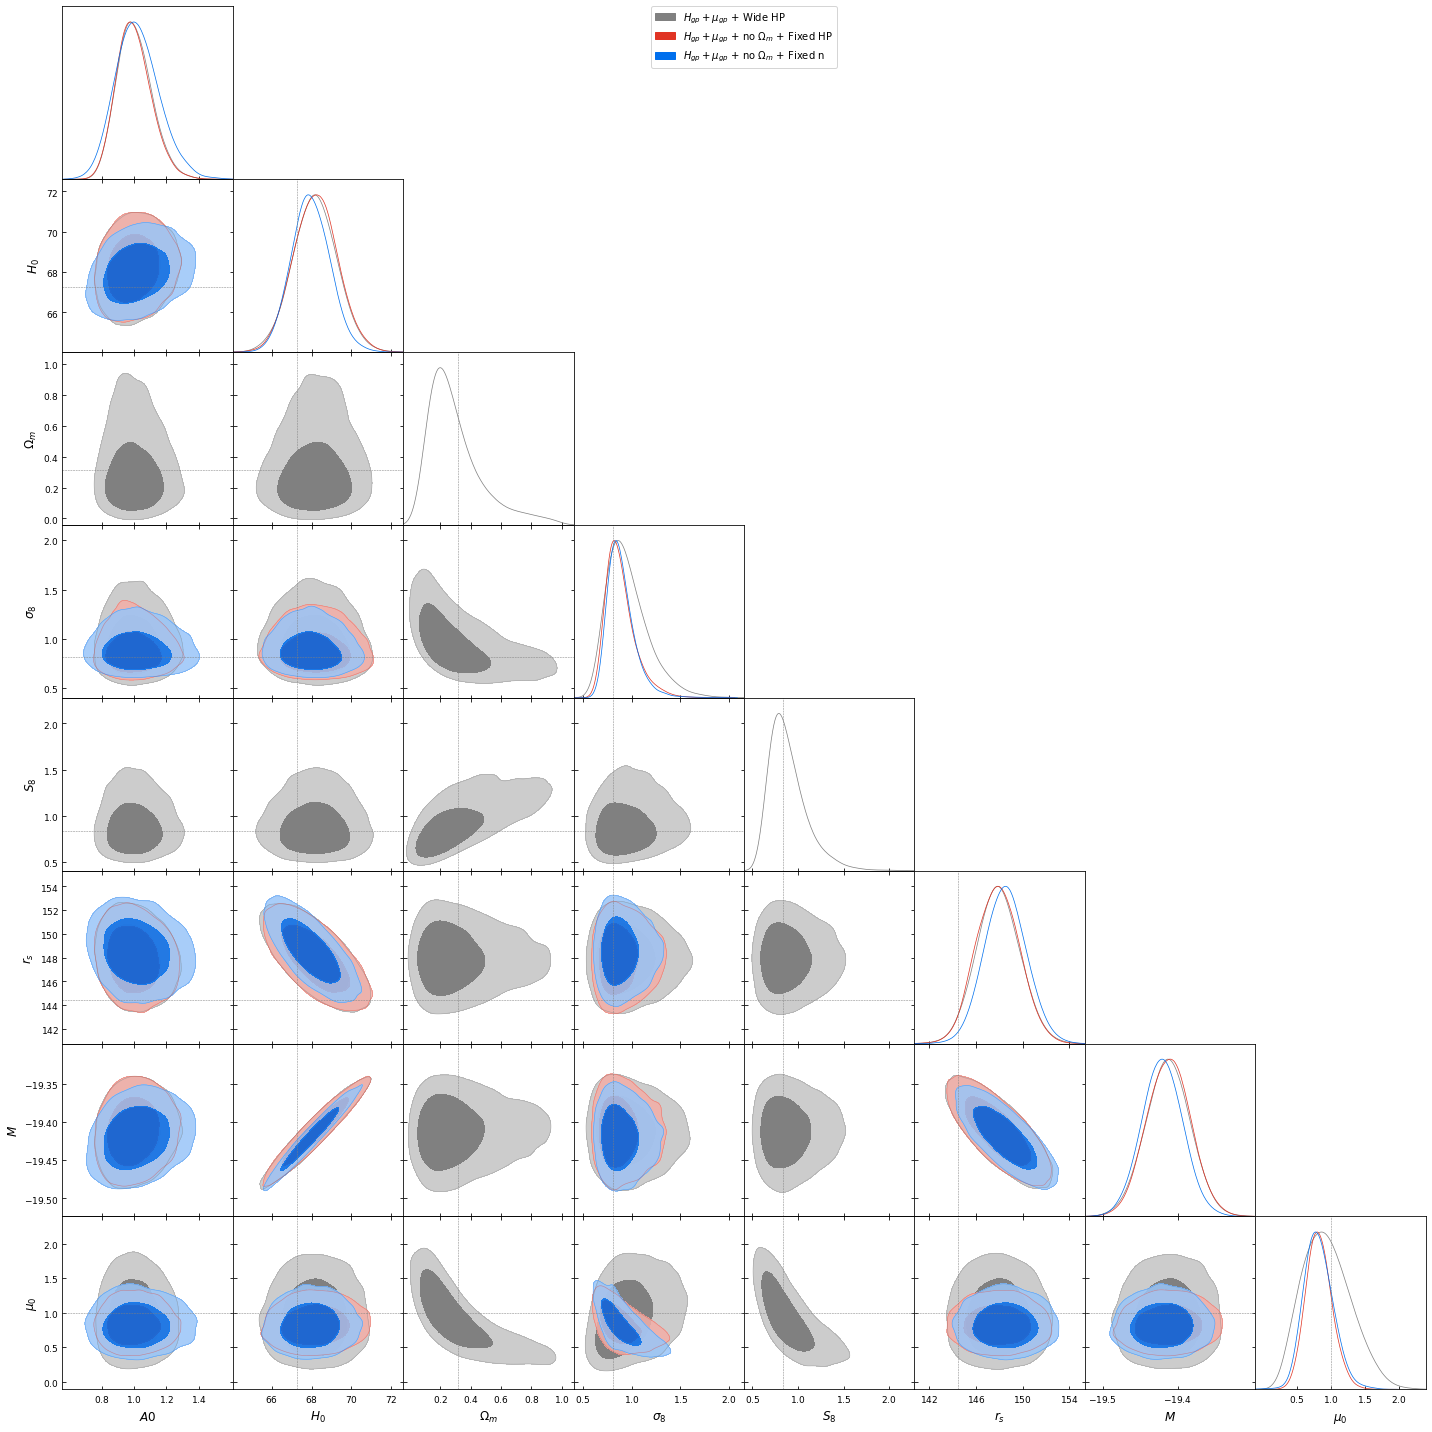

In [75]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([HXi_widehp_samples, HXi_noWm_samples, HXi_n_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                        'rd':144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

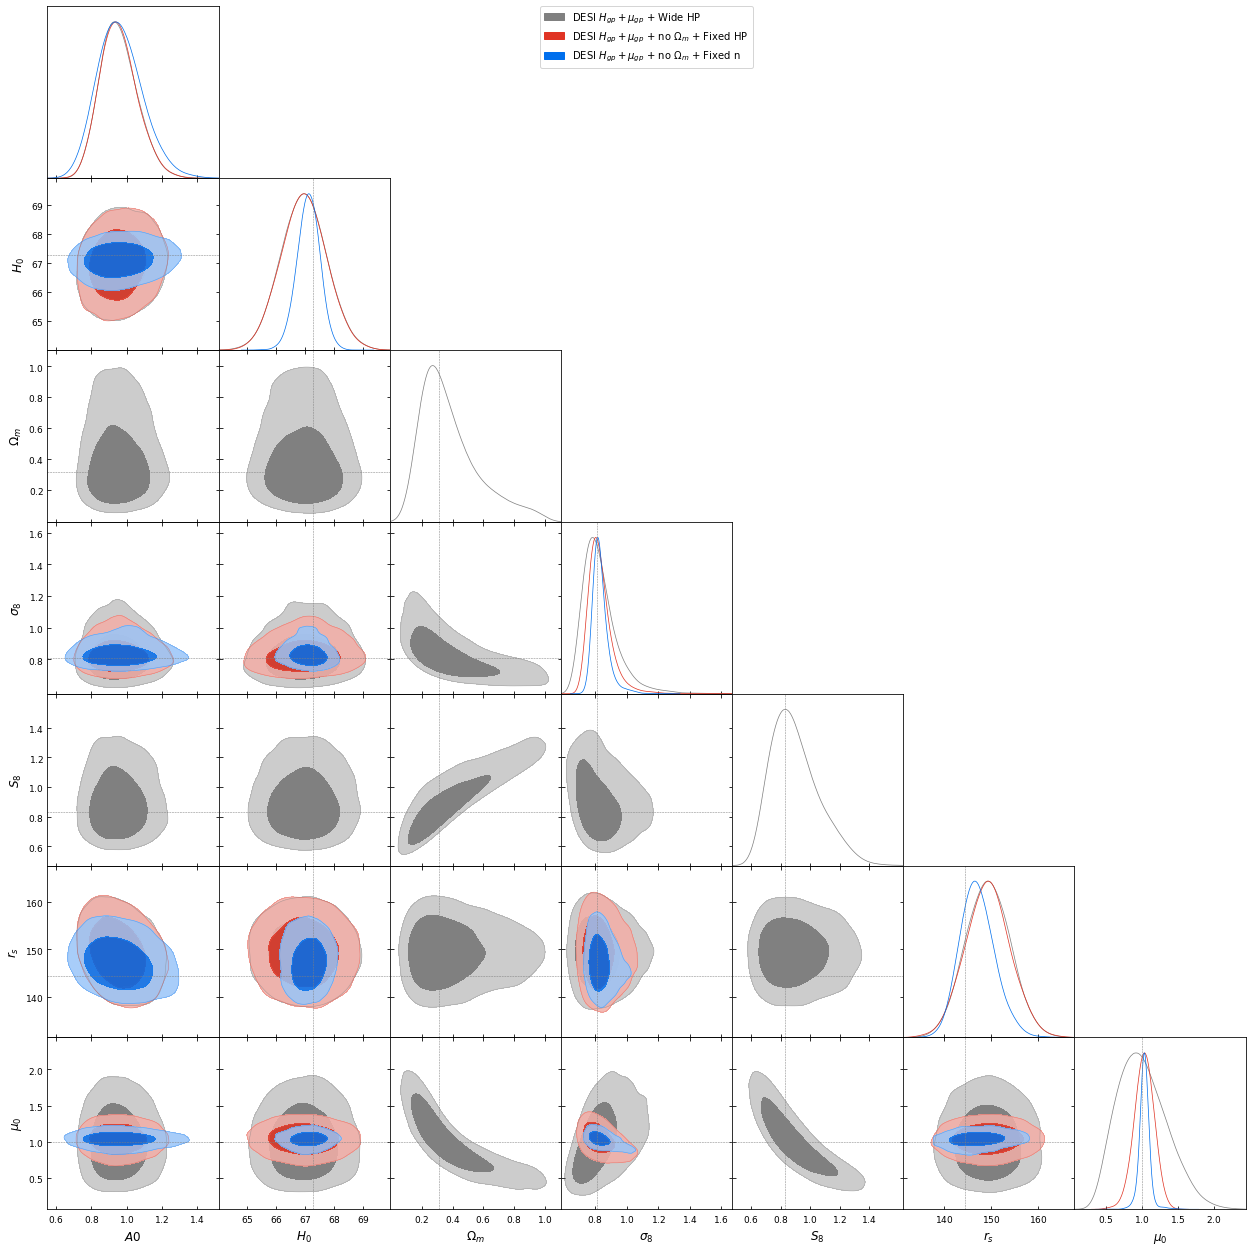

In [76]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_HXi_widehp_samples, DESI_HXi_noWm_samples, DESI_HXi_n_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                        'rd':144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

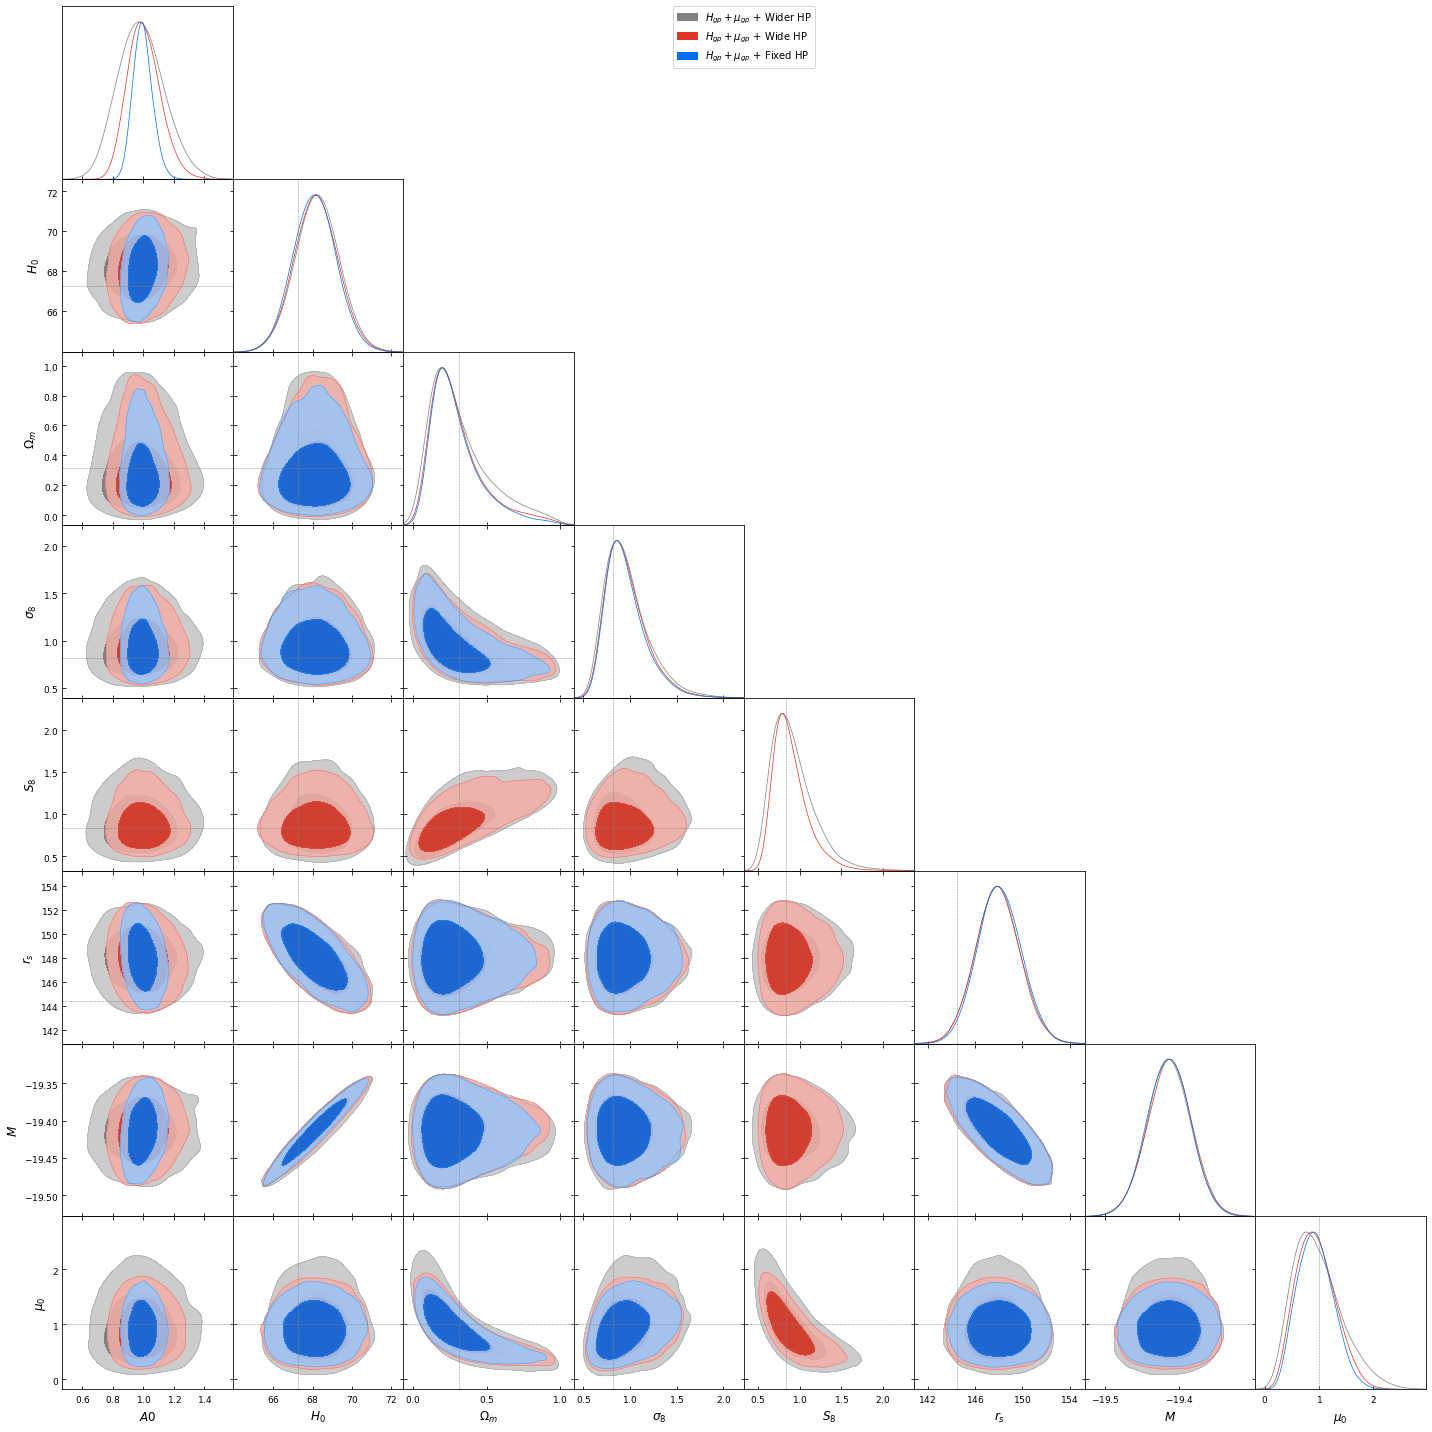

In [77]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([HXi_widerhp_samples, HXi_widehp_samples, HXi_hp_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                        'rd':144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

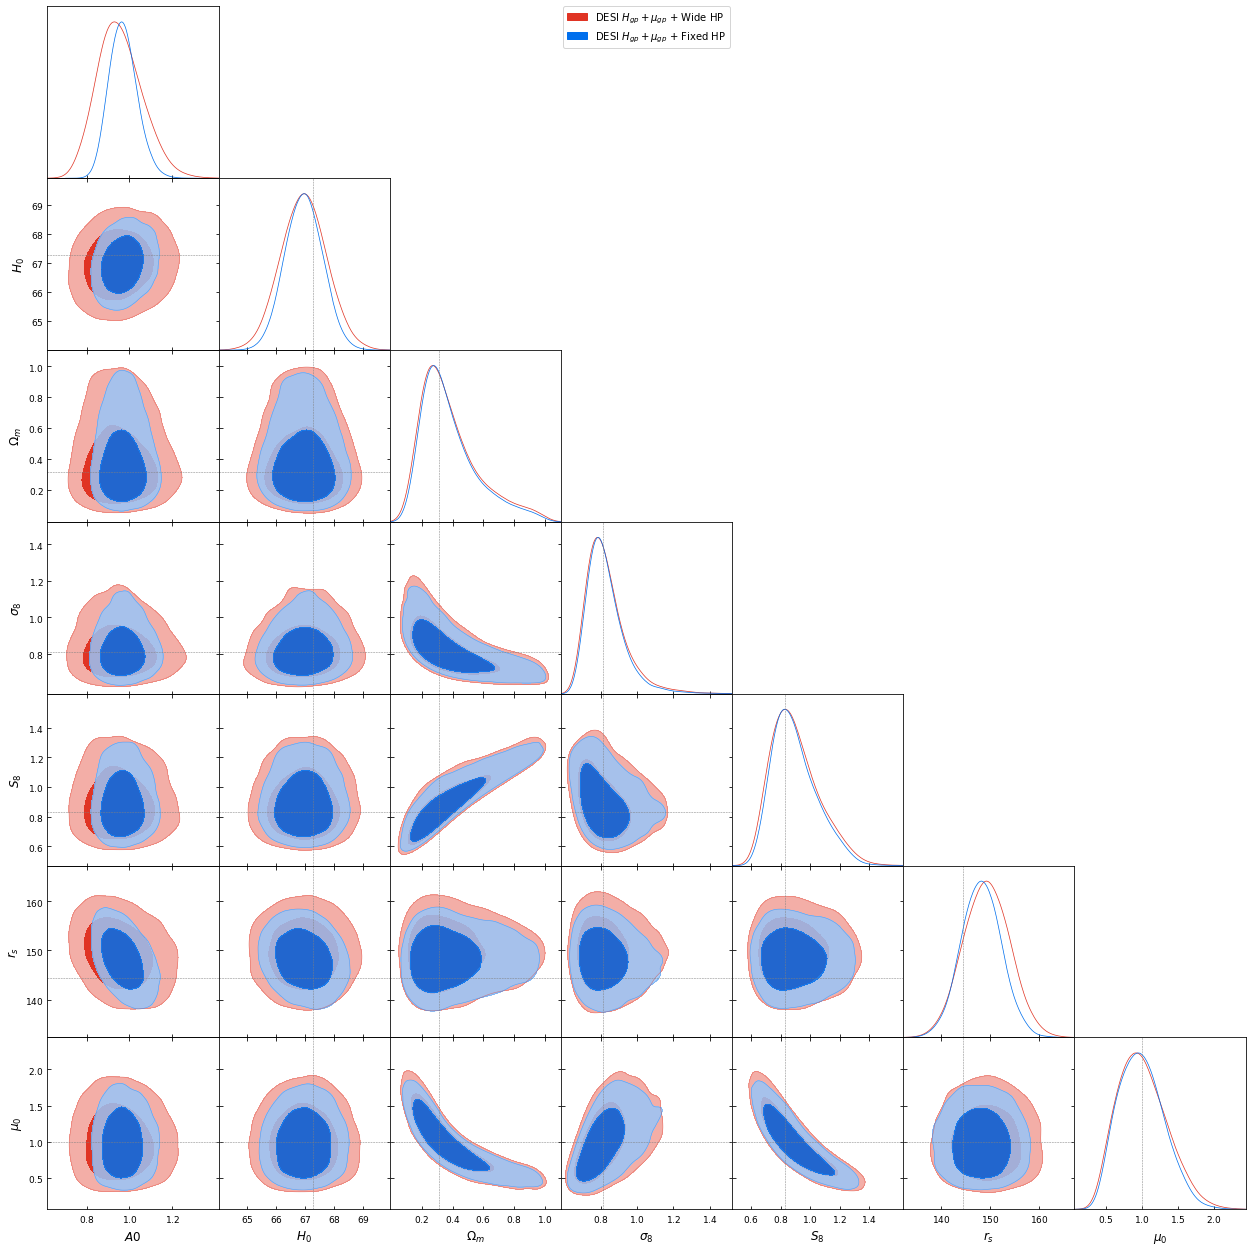

In [78]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([ DESI_HXi_widehp_samples, DESI_HXi_hp_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                        'rd':144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_LCDM_samples, DESIts_LCDM_samples, DESIhs_LCDM_samples, DESIfs_LCDM_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                        'rd':144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_LCDM_samples, DESI2n_LCDM_samples, DESI5n_LCDM_samples, DESI10n_LCDM_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                        'rd':144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([Xi_LCDM_samples, Xi_P18_samples, Xi_P18_full_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                        'rd':144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([Xi_LCDM_samples, LCDM_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd': 144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([Xi_wCDM_samples, Xi_LCDM_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_m_mean': data_class.cosmo.Omega_m(),
                         'w0': -1,
                         'wa': 0,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd': 144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_data.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([HXi_samples, HXi_hp_samples],
                filled=True,
                markers={'n_H':0.1,
                         'n_Xi':0.35,
                         'l_H':1.0,
                         'l_Xi':1.0})
                         #'H0_gp':100*data_class.cosmo.h(),
                         #'Omega_m': data_class.cosmo.Omega_m(),
                         #'s80': data_class.cosmo.sigma8(), 
                         #'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         #'rd': 144.46,
                         #'M': -19.2,
                         #'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_HXi_samples, DESI_HXi_hp_samples],
                filled=True,
                markers={'n_H':0.1,
                         'n_Xi':0.35,
                         'l_H':1.0,
                         'l_Xi':1.0})
                         #'H0_gp':100*data_class.cosmo.h(),
                         #'Omega_m': data_class.cosmo.Omega_m(),
                         #'s80': data_class.cosmo.sigma8(), 
                         #'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         #'rd': 144.46,
                         #'M': -19.2,
                         #'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([HXi_hp_samples, DESI_HXi_hp_samples],
                filled=True,
                markers={'n_H':0.1,
                         'n_Xi':0.35,
                         'l_H':1.0,
                         'l_Xi':1.0})
                         #'H0_gp':100*data_class.cosmo.h(),
                         #'Omega_m': data_class.cosmo.Omega_m(),
                         #'s80': data_class.cosmo.sigma8(), 
                         #'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         #'rd': 144.46,
                         #'M': -19.2,
                         #'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

In [ ]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([HXi_samples, DESI_HXi_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd': 144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

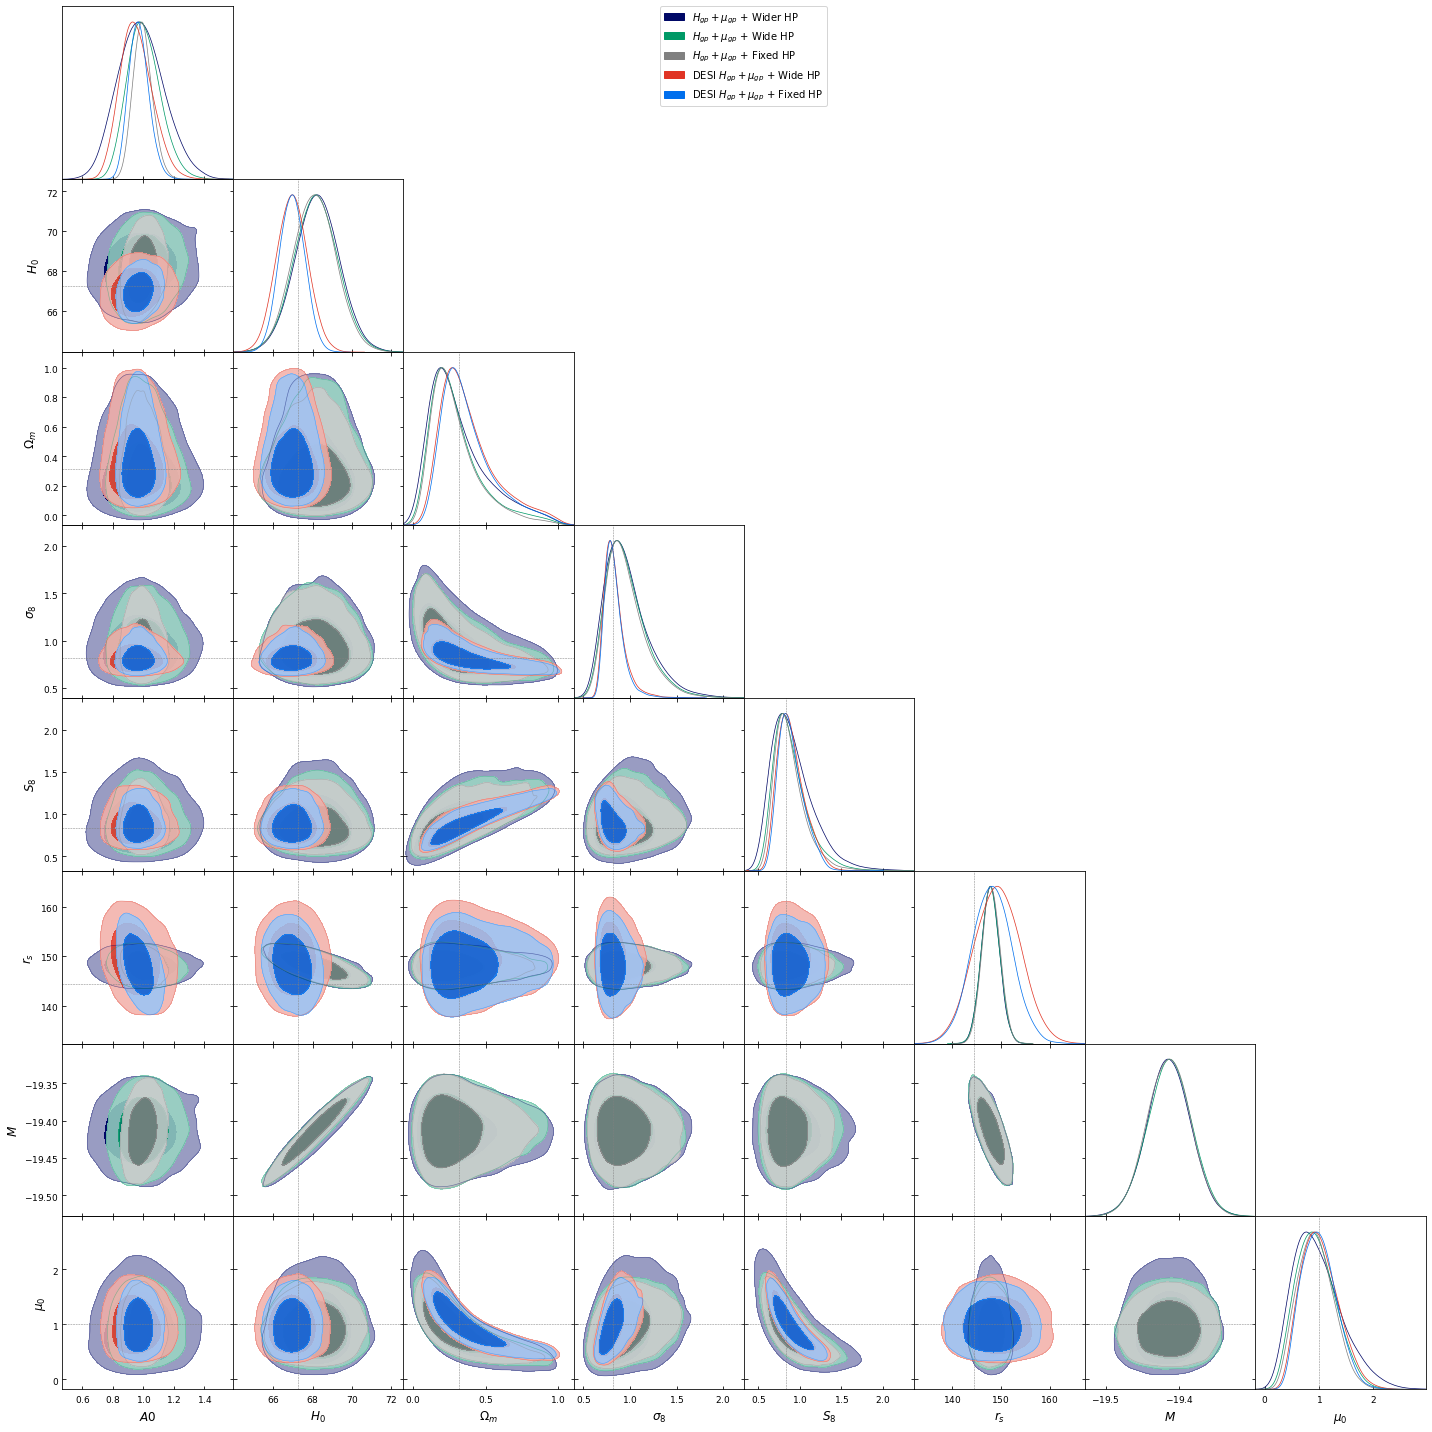

In [92]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([HXi_widerhp_samples, HXi_widehp_samples, HXi_hp_samples, DESI_HXi_widehp_samples, DESI_HXi_hp_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd': 144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

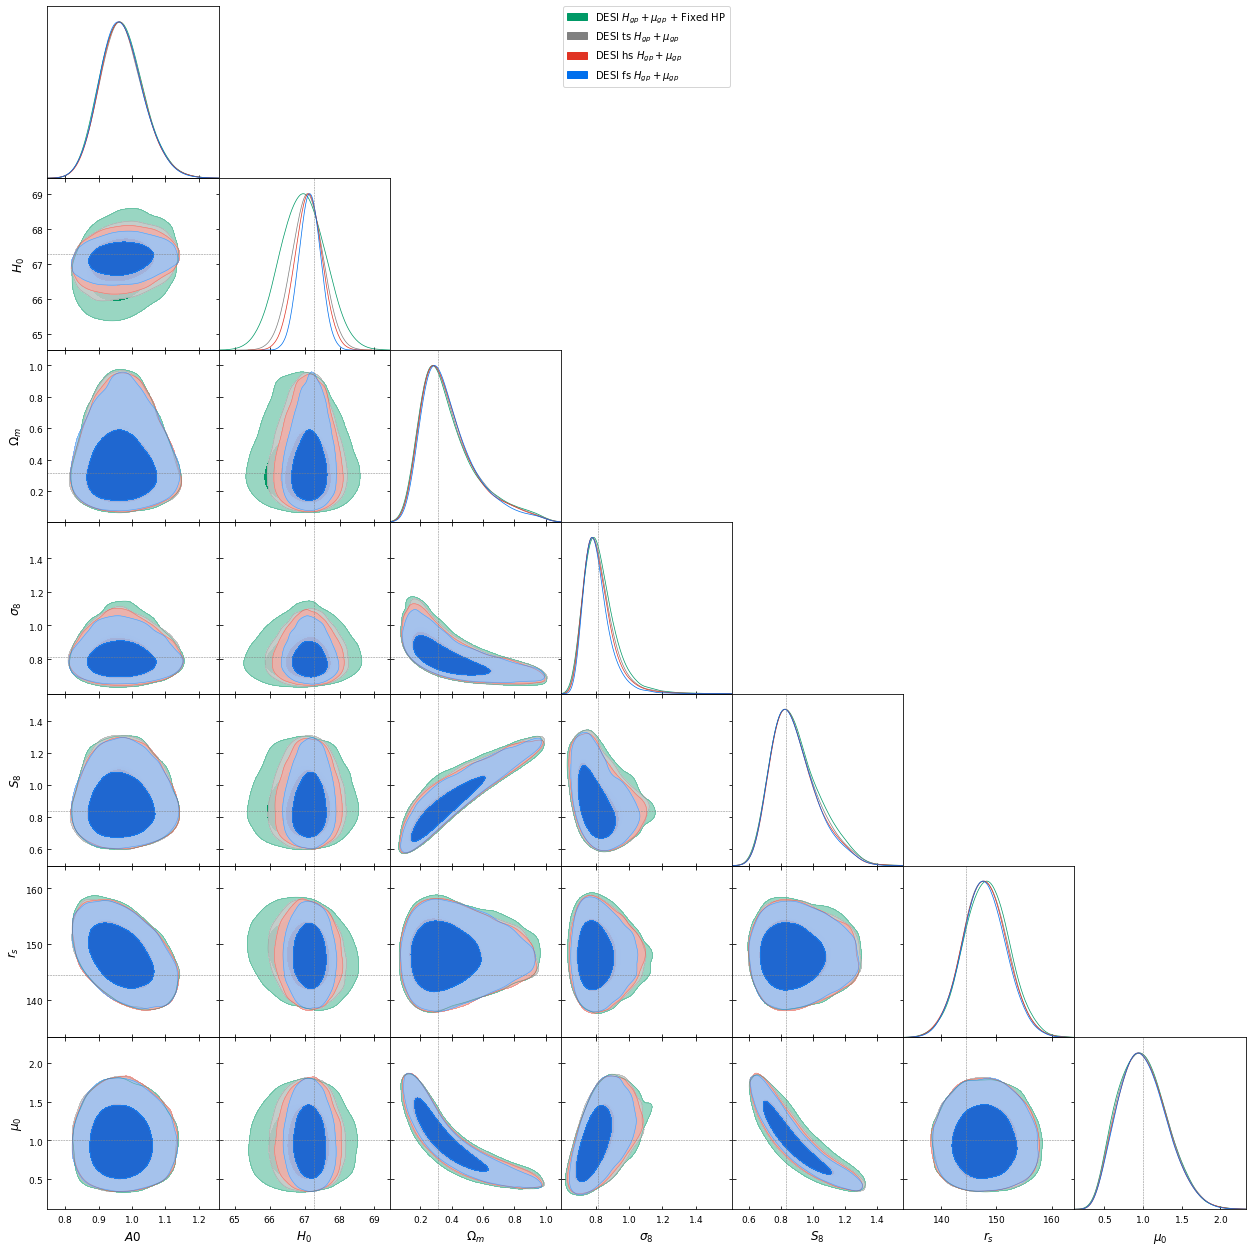

In [63]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_HXi_hp_samples, DESIts_HXi_samples, DESIhs_HXi_samples, DESIfs_HXi_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd': 144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

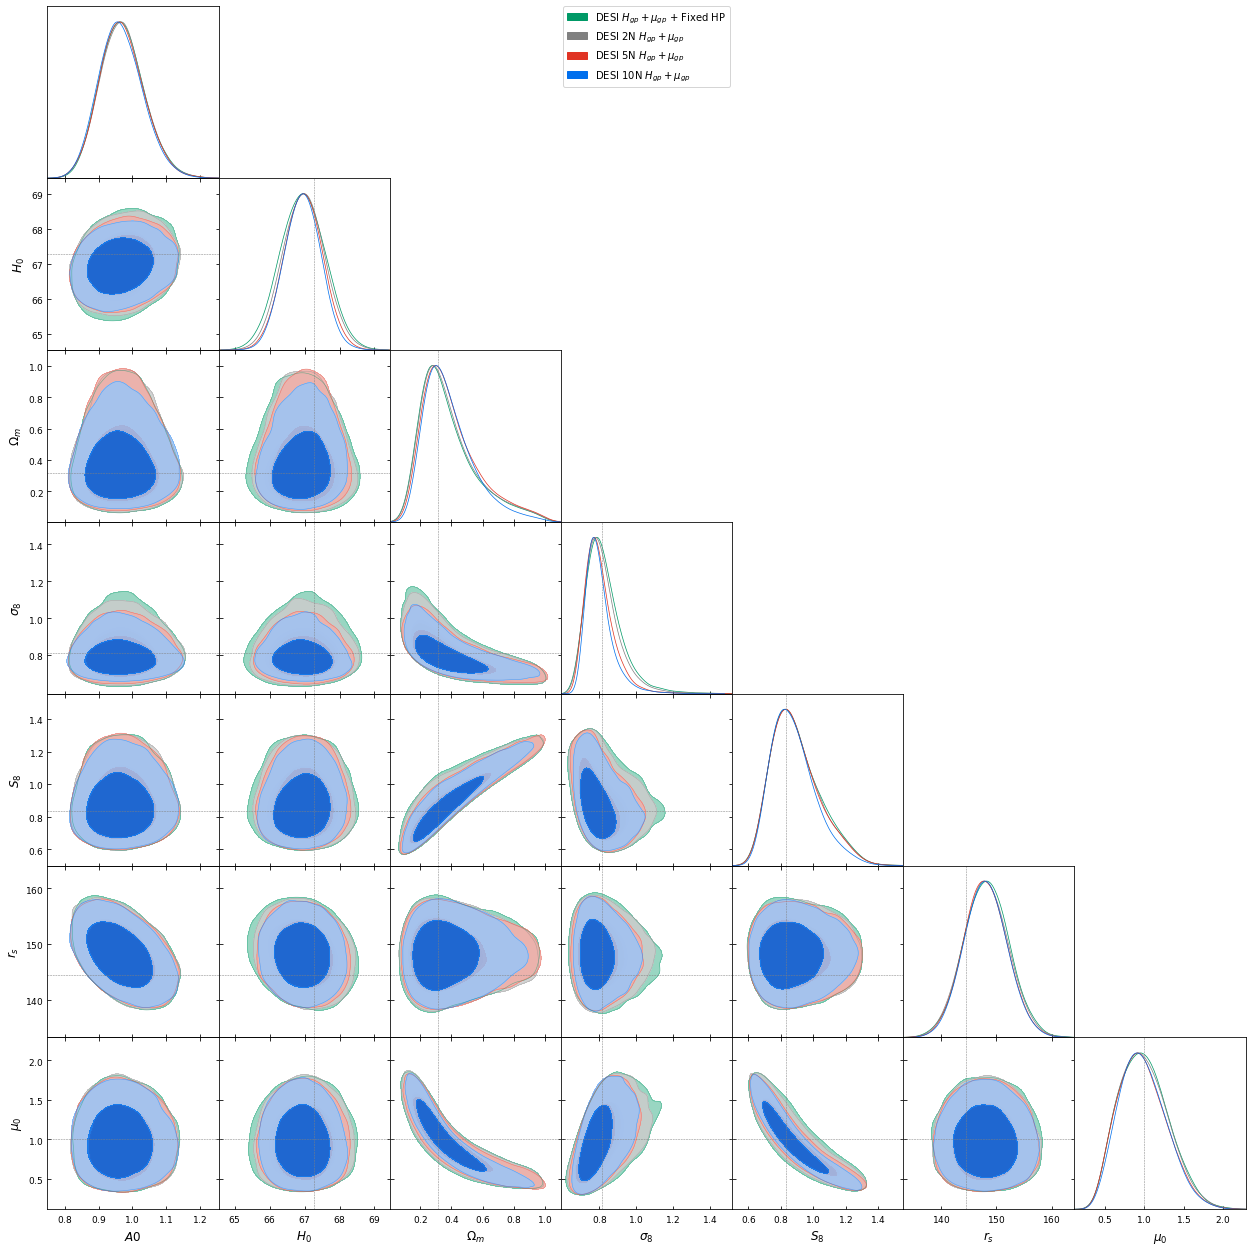

In [62]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_HXi_hp_samples, DESI2n_HXi_samples, DESI5n_HXi_samples, DESI10n_HXi_samples],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3),
                         'rd': 144.46,
                         'M': -19.2,
                         'mu_0': 1})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/beyond_gp_figures/triangle_Xi_H.pdf')

# GP's

In [13]:
dXi_Xi_P18_m, dXi_Xi_P18_s = get_m_s(1+Xi_P18['DXiz'])
dXi_Xi_P18_hp_m, dXi_Xi_P18_hp_s = get_m_s(1+Xi_P18_hp['DXiz'])
dXi_Xi_P18_widehp_m, dXi_Xi_P18_widehp_s = get_m_s(1+Xi_P18_widehp['DXiz'])
dXi_Xi_LCDM_m, dXi_Xi_LCDM_s = get_m_s(1+Xi_LCDM['DXiz'])
dXi_Xi_wCDM_m, dXi_Xi_wCDM_s = get_m_s(1+Xi_wCDM['DXiz'])
dXi_HXi_m, dXi_HXi_s = get_m_s(1+HXi['DXiz'])
dXi_HXi_hp_m, dXi_HXi_hp_s = get_m_s(1+HXi_hp['DXiz'])
dXi_HXi_n_m, dXi_HXi_n_s = get_m_s(1+HXi_n['DXiz'])
dXi_HXi_widehp_m, dXi_HXi_widehp_s = get_m_s(1+HXi_widehp['DXiz'])
dXi_HXi_widerhp_m, dXi_HXi_widerhp_s = get_m_s(1+HXi_widerhp['DXiz'])
dXi_HXi_noWm_m, dXi_HXi_noWm_s = get_m_s(1+HXi_noWm['DXiz'])
dXi_DESI_HXi_m, dXi_DESI_HXi_s = get_m_s(1+DESI_HXi['DXiz'])
dXi_DESI_HXi_hp_m, dXi_DESI_HXi_hp_s = get_m_s(1+DESI_HXi_hp['DXiz'])
dXi_DESI_HXi_n_m, dXi_DESI_HXi_n_s = get_m_s(1+DESI_HXi_n['DXiz'])
dXi_DESI_HXi_widehp_m, dXi_DESI_HXi_widehp_s = get_m_s(1+DESI_HXi_widehp['DXiz'])
dXi_DESI_HXi_noWm_m, dXi_DESI_HXi_noWm_s = get_m_s(1+DESI_HXi_noWm['DXiz'])
dXi_DESIts_HXi_m, dXi_DESIts_HXi_s = get_m_s(1+DESIts_HXi['DXiz'])
dXi_DESIhs_HXi_m, dXi_DESIhs_HXi_s = get_m_s(1+DESIhs_HXi['DXiz'])
dXi_DESIfs_HXi_m, dXi_DESIfs_HXi_s = get_m_s(1+DESIfs_HXi['DXiz'])
dXi_DESI2n_HXi_m, dXi_DESI2n_HXi_s = get_m_s(1+DESI2n_HXi['DXiz'])
dXi_DESI5n_HXi_m, dXi_DESI5n_HXi_s = get_m_s(1+DESI5n_HXi['DXiz'])
dXi_DESI10n_HXi_m, dXi_DESI10n_HXi_s = get_m_s(1+DESI10n_HXi['DXiz'])

In [36]:
dfs8_Xi_P18_full_m, dfs8_Xi_P18_full_s = get_m_s(Xi_P18_full['fs8z']/np.mean(Xi_P18_full['fs8z'],0)-1)
dfs8_Xi_LCDM_m, dfs8_Xi_LCDM_s = get_m_s(Xi_LCDM['fs8z']/np.mean(Xi_LCDM['fs8z'],0)-1)
dfs8_Xi_wCDM_m, dfs8_Xi_wCDM_s = get_m_s(Xi_wCDM['fs8z']/np.mean(Xi_wCDM['fs8z'],0)-1)
dfs8_HXi_m, dfs8_HXi_s = get_m_s(HXi['fs8z']/np.mean(HXi['fs8z'],0)-1)
dfs8_HXi_hp_m, dfs8_HXi_hp_s = get_m_s(HXi_hp['fs8z']/np.mean(HXi_hp['fs8z'],0)-1)
dfs8_DESI_HXi_m, dfs8_DESI_HXi_s = get_m_s(DESI_HXi['fs8z']/np.mean(DESI_HXi['fs8z'],0)-1)
dfs8_DESI_HXi_hp_m, dfs8_DESI_HXi_hp_s = get_m_s(DESI_HXi_hp['fs8z']/np.mean(DESI_HXi_hp['fs8z'],0)-1)
dfs8_DESIts_HXi_m, dfs8_DESIts_HXi_s = get_m_s(DESIts_HXi['fs8z']/np.mean(DESIts_HXi['fs8z'],0)-1)
dfs8_DESIhs_HXi_m, dfs8_DESIhs_HXi_s = get_m_s(DESIhs_HXi['fs8z']/np.mean(DESIhs_HXi['fs8z'],0)-1)
dfs8_DESIfs_HXi_m, dfs8_DESIfs_HXi_s = get_m_s(DESIfs_HXi['fs8z']/np.mean(DESIfs_HXi['fs8z'],0)-1)
dfs8_DESI2n_HXi_m, dfs8_DESI2n_HXi_s = get_m_s(DESI2n_HXi['fs8z']/np.mean(DESI2n_HXi['fs8z'],0)-1)
dfs8_DESI5n_HXi_m, dfs8_DESI5n_HXi_s = get_m_s(DESI5n_HXi['fs8z']/np.mean(DESI5n_HXi['fs8z'],0)-1)
dfs8_DESI10n_HXi_m, dfs8_DESI10n_HXi_s = get_m_s(DESI10n_HXi['fs8z']/np.mean(DESI10n_HXi['fs8z'],0)-1)

In [37]:
dfs8_DESI_LCDM_m, dfs8_DESI_LCDM_s = get_m_s(DESI_LCDM['fs8z']/np.mean(DESI_LCDM['fs8z'],0)-1)
dfs8_DESIts_LCDM_m, dfs8_DESIts_LCDM_s = get_m_s(DESIts_LCDM['fs8z']/np.mean(DESIts_LCDM['fs8z'],0)-1)
dfs8_DESIhs_LCDM_m, dfs8_DESIhs_LCDM_s = get_m_s(DESIhs_LCDM['fs8z']/np.mean(DESIhs_LCDM['fs8z'],0)-1)
dfs8_DESIfs_LCDM_m, dfs8_DESIfs_LCDM_s = get_m_s(DESIfs_LCDM['fs8z']/np.mean(DESIfs_LCDM['fs8z'],0)-1)
dfs8_DESI2n_LCDM_m, dfs8_DESI2n_LCDM_s = get_m_s(DESI2n_LCDM['fs8z']/np.mean(DESI2n_LCDM['fs8z'],0)-1)
dfs8_DESI5n_LCDM_m, dfs8_DESI5n_LCDM_s = get_m_s(DESI5n_LCDM['fs8z']/np.mean(DESI5n_LCDM['fs8z'],0)-1)
dfs8_DESI10n_LCDM_m, dfs8_DESI10n_LCDM_s = get_m_s(DESI10n_LCDM['fs8z']/np.mean(DESI10n_LCDM['fs8z'],0)-1)

In [110]:
dH_Xi_P18_full_m, dH_Xi_P18_full_s = get_m_s(Xi_P18_full['Hz']/np.mean(Xi_P18_full['Hz'],0)-1)
dH_Xi_LCDM_m, dH_Xi_LCDM_s = get_m_s(Xi_LCDM['Hz']/np.mean(Xi_P18_full['Hz'],0)-1)
dH_Xi_wCDM_m, dH_Xi_wCDM_s = get_m_s(Xi_wCDM['Hz']/np.mean(Xi_P18_full['Hz'],0)-1)
dH_HXi_m, dH_HXi_s = get_m_s(HXi['Hz']/np.mean(HXi['Hz'],0)-1)
dH_HXi_hp_m, dH_HXi_hp_s = get_m_s(HXi_hp['Hz']/np.mean(HXi_hp['Hz'],0)-1)
dH_DESI_HXi_m, dH_DESI_HXi_s = get_m_s(DESI_HXi['Hz']/np.mean(DESI_HXi['Hz'],0)-1)
dH_DESI_HXi_hp_m, dH_DESI_HXi_hp_s = get_m_s(DESI_HXi_hp['Hz']/np.mean(DESI_HXi_hp['Hz'],0)-1)
dH_DESIhs_HXi_m, dH_DESIhs_HXi_s = get_m_s(DESIhs_HXi['Hz']/np.mean(DESIhs_HXi['Hz'],0)-1)
dH_DESIfs_HXi_m, dH_DESIfs_HXi_s = get_m_s(DESIfs_HXi['Hz']/np.mean(DESIfs_HXi['Hz'],0)-1)
dH_DESI10n_HXi_m, dH_DESI10n_HXi_s = get_m_s(DESI10n_HXi['Hz']/np.mean(DESI10n_HXi['Hz'],0)-1)
dH_Euclid_HXi_m, dH_Euclid_HXi_s = get_m_s(Euclid_HXi['Hz']/np.mean(Euclid_HXi['Hz'],0)-1)

In [39]:
dH_DESI_LCDM_m, dH_DESI_LCDM_s = get_m_s(DESI_LCDM['Hz']/np.mean(DESI_LCDM['Hz'],0)-1)
dH_DESIts_LCDM_m, dH_DESIts_LCDM_s = get_m_s(DESIts_LCDM['Hz']/np.mean(DESIts_LCDM['Hz'],0)-1)
dH_DESIhs_LCDM_m, dH_DESIhs_LCDM_s = get_m_s(DESIhs_LCDM['Hz']/np.mean(DESIhs_LCDM['Hz'],0)-1)
dH_DESIfs_LCDM_m, dH_DESIfs_LCDM_s = get_m_s(DESIfs_LCDM['Hz']/np.mean(DESIfs_LCDM['Hz'],0)-1)
dH_DESI2n_LCDM_m, dH_DESI2n_LCDM_s = get_m_s(DESI2n_LCDM['Hz']/np.mean(DESI2n_LCDM['Hz'],0)-1)
dH_DESI5n_LCDM_m, dH_DESI5n_LCDM_s = get_m_s(DESI5n_LCDM['Hz']/np.mean(DESI5n_LCDM['Hz'],0)-1)
dH_DESI10n_LCDM_m, dH_DESI10n_LCDM_s = get_m_s(DESI10n_LCDM['Hz']/np.mean(DESI10n_LCDM['Hz'],0)-1)

In [40]:
dHgp_HXi_m, dHgp_HXi_s = get_m_s(HXi['DHz'])
dHgp_HXi_hp_m, dHgp_HXi_hp_s = get_m_s(HXi_hp['DHz'])
dHgp_HXi_n_m, dHgp_HXi_n_s = get_m_s(HXi_n['DHz'])
dHgp_HXi_widehp_m, dHgp_HXi_widehp_s = get_m_s(HXi_widehp['DHz'])
dHgp_HXi_widerhp_m, dHgp_HXi_widerhp_s = get_m_s(HXi_widerhp['DHz'])
dHgp_HXi_noWm_m, dHgp_HXi_noWm_s = get_m_s(HXi_noWm['DHz'])
dHgp_DESI_HXi_m, dHgp_DESI_HXi_s = get_m_s(DESI_HXi['DHz'])
dHgp_DESI_HXi_n_m, dHgp_DESI_HXi_n_s = get_m_s(DESI_HXi_n['DHz'])
dHgp_DESI_HXi_hp_m, dHgp_DESI_HXi_hp_s = get_m_s(DESI_HXi_hp['DHz'])
dHgp_DESI_HXi_widehp_m, dHgp_DESI_HXi_widehp_s = get_m_s(DESI_HXi_widehp['DHz'])
dHgp_DESI_HXi_noWm_m, dHgp_DESI_HXi_noWm_s = get_m_s(DESI_HXi_noWm['DHz'])
dHgp_DESIts_HXi_m, dHgp_DESIts_HXi_s = get_m_s(DESIts_HXi['DHz'])
dHgp_DESIhs_HXi_m, dHgp_DESIhs_HXi_s = get_m_s(DESIhs_HXi['DHz'])
dHgp_DESIfs_HXi_m, dHgp_DESIfs_HXi_s = get_m_s(DESIfs_HXi['DHz'])
dHgp_DESI2n_HXi_m, dHgp_DESI2n_HXi_s = get_m_s(DESI2n_HXi['DHz'])
dHgp_DESI5n_HXi_m, dHgp_DESI5n_HXi_s = get_m_s(DESI5n_HXi['DHz'])
dHgp_DESI10n_HXi_m, dHgp_DESI10n_HXi_s = get_m_s(DESI10n_HXi['DHz'])

/tmp/ipykernel_3022/256818607.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


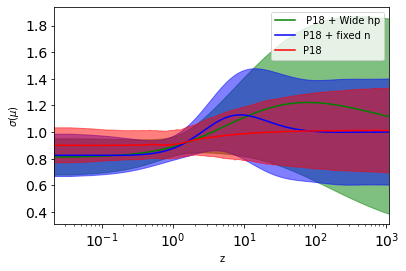

In [15]:
plt.plot(z_arr,  dXi_Xi_P18_widehp_m, color ='g', label=' P18 + Wide hp')
plt.fill_between(z_arr, dXi_Xi_P18_widehp_m+dXi_Xi_P18_widehp_s,
                 dXi_Xi_P18_widehp_m-dXi_Xi_P18_widehp_s, color='g', alpha=.5)

plt.plot(z_arr,  dXi_Xi_P18_hp_m, color ='b', label='P18 + fixed n')
plt.fill_between(z_arr, dXi_Xi_P18_hp_m+dXi_Xi_P18_hp_s,
                 dXi_Xi_P18_hp_m-dXi_Xi_P18_hp_s, color='b', alpha=.5)

plt.plot(z_arr,  dXi_Xi_P18_m, color ='r', label='P18')
plt.fill_between(z_arr, dXi_Xi_P18_m+dXi_Xi_P18_s,
                 dXi_Xi_P18_m-dXi_Xi_P18_s, color='r', alpha=.5)

plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
#plt.ylim(0., 0.5)
plt.xlabel("z")
plt.ylabel(r"$ \sigma( \mu)$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

/tmp/ipykernel_3022/2394888012.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


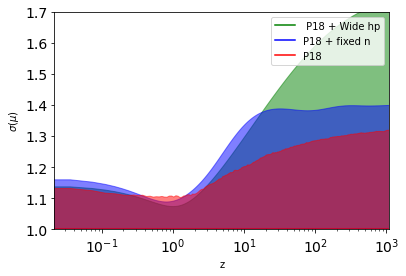

In [23]:
plt.plot(z_arr,  np.ones_like(dXi_Xi_P18_widehp_m), color ='g', label=' P18 + Wide hp')
plt.fill_between(z_arr, 1+dXi_Xi_P18_widehp_s,
                 1-dXi_Xi_P18_widehp_s, color='g', alpha=.5)

plt.plot(z_arr,  np.ones_like(dXi_Xi_P18_hp_m), color ='b', label='P18 + fixed n')
plt.fill_between(z_arr, 1+dXi_Xi_P18_hp_s,
                 1-dXi_Xi_P18_hp_s, color='b', alpha=.5)

plt.plot(z_arr,  np.ones_like(dXi_Xi_P18_m), color ='r', label='P18')
plt.fill_between(z_arr, 1+dXi_Xi_P18_s,
                 1-dXi_Xi_P18_s, color='r', alpha=.5)

plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
plt.ylim(1., 1.7)
plt.xlabel("z")
plt.ylabel(r"$ \sigma( \mu)$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

/tmp/ipykernel_934/3554679151.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
/tmp/ipykernel_934/3554679151.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


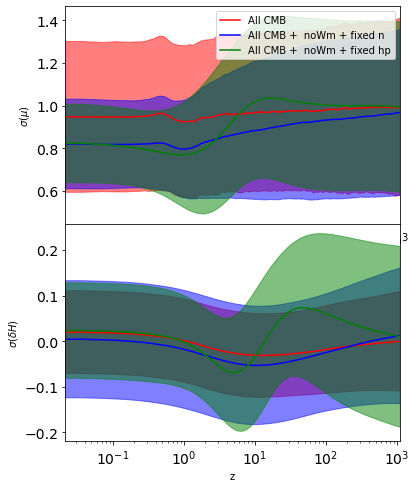

In [45]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  dXi_HXi_m, color ='r', label='All CMB')
plt.fill_between(z_arr, dXi_HXi_m+dXi_HXi_s,
                 dXi_HXi_m-dXi_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  dXi_HXi_n_m, color ='b', label='All CMB +  noWm + fixed n')
plt.fill_between(z_arr, dXi_HXi_n_m+dXi_HXi_n_s,
                 dXi_HXi_n_m-dXi_HXi_n_s, color='b', alpha=.5)
plt.plot(z_arr,  dXi_HXi_noWm_m, color ='g', label='All CMB +  noWm + fixed hp')
plt.fill_between(z_arr, dXi_HXi_noWm_m+dXi_HXi_noWm_s,
                 dXi_HXi_noWm_m-dXi_HXi_noWm_s, color='g', alpha=.5)

plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
#plt.ylim(0., 0.5)
plt.xlabel("z")
plt.ylabel(r"$ \sigma( \mu)$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  dHgp_HXi_m, color ='r', label='All CMB')
plt.fill_between(z_arr, dHgp_HXi_m+dHgp_HXi_s,
                 dHgp_HXi_m-dHgp_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  dHgp_HXi_n_m, color ='b', label='All CMB +  noWm + fixed n')
plt.fill_between(z_arr, dHgp_HXi_n_m+dHgp_HXi_n_s,
                 dHgp_HXi_n_m-dHgp_HXi_n_s, color='b', alpha=.5)
plt.plot(z_arr,  dHgp_HXi_noWm_m, color ='g', label='All CMB +  noWm + fixed hp')
plt.fill_between(z_arr, dHgp_HXi_noWm_m+dHgp_HXi_noWm_s,
                 dHgp_HXi_noWm_m-dHgp_HXi_noWm_s, color='g', alpha=.5)


plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
#plt.ylim(0., 0.12)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(\delta H)$")
#plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

/tmp/ipykernel_934/2449459156.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
/tmp/ipykernel_934/2449459156.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


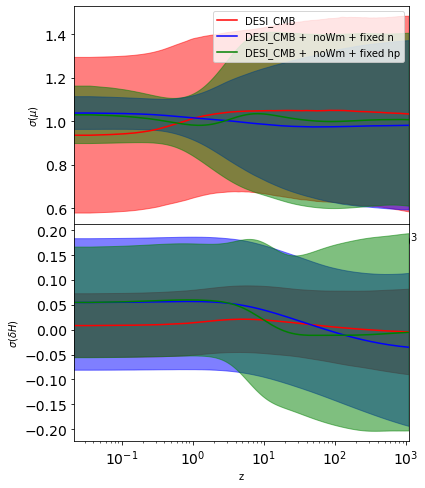

In [46]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  dXi_DESI_HXi_m, color ='r', label='DESI_CMB')
plt.fill_between(z_arr, dXi_DESI_HXi_m+dXi_DESI_HXi_s,
                 dXi_DESI_HXi_m-dXi_DESI_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  dXi_DESI_HXi_n_m, color ='b', label='DESI_CMB +  noWm + fixed n')
plt.fill_between(z_arr, dXi_DESI_HXi_n_m+dXi_DESI_HXi_n_s,
                 dXi_DESI_HXi_n_m-dXi_DESI_HXi_n_s, color='b', alpha=.5)
plt.plot(z_arr,  dXi_DESI_HXi_noWm_m, color ='g', label='DESI_CMB +  noWm + fixed hp')
plt.fill_between(z_arr, dXi_DESI_HXi_noWm_m+dXi_DESI_HXi_noWm_s,
                 dXi_DESI_HXi_noWm_m-dXi_DESI_HXi_noWm_s, color='g', alpha=.5)

plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
#plt.ylim(0., 0.5)
plt.xlabel("z")
plt.ylabel(r"$ \sigma( \mu)$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  dHgp_DESI_HXi_m, color ='r', label='DESI_CMB')
plt.fill_between(z_arr, dHgp_DESI_HXi_m+dHgp_DESI_HXi_s,
                 dHgp_DESI_HXi_m-dHgp_DESI_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  dHgp_DESI_HXi_n_m, color ='b', label='DESI_CMB +  noWm + fixed n')
plt.fill_between(z_arr, dHgp_DESI_HXi_n_m+dHgp_HXi_n_s,
                 dHgp_DESI_HXi_n_m-dHgp_DESI_HXi_n_s, color='b', alpha=.5)
plt.plot(z_arr,  dHgp_DESI_HXi_noWm_m, color ='g', label='DESI_CMB +  noWm + fixed hp')
plt.fill_between(z_arr, dHgp_DESI_HXi_noWm_m+dHgp_DESI_HXi_noWm_s,
                 dHgp_DESI_HXi_noWm_m-dHgp_DESI_HXi_noWm_s, color='g', alpha=.5)


plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
#plt.ylim(0., 0.12)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(\delta H)$")
#plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

/tmp/ipykernel_934/648395700.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
/tmp/ipykernel_934/648395700.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


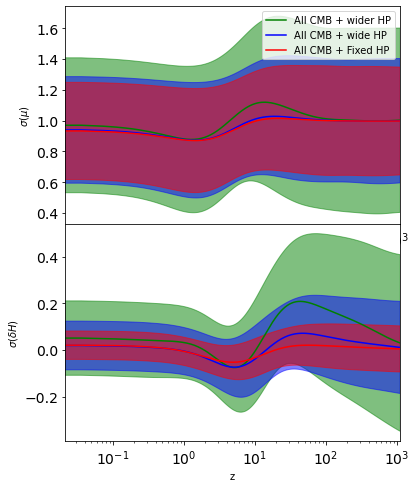

In [79]:

fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  dXi_HXi_widerhp_m, color ='g', label='All CMB + wider HP')
plt.fill_between(z_arr, dXi_HXi_widerhp_m+dXi_HXi_widerhp_s,
                 dXi_HXi_widerhp_m-dXi_HXi_widerhp_s, color='g', alpha=.5)
plt.plot(z_arr,  dXi_HXi_widehp_m, color ='b', label='All CMB + wide HP')
plt.fill_between(z_arr, dXi_HXi_widehp_m+dXi_HXi_widehp_s,
                 dXi_HXi_widehp_m-dXi_HXi_widehp_s, color='b', alpha=.5)
plt.plot(z_arr,  dXi_HXi_hp_m, color ='r', label='All CMB + Fixed HP')
plt.fill_between(z_arr, dXi_HXi_hp_m+dXi_HXi_hp_s,
                 dXi_HXi_hp_m-dXi_HXi_hp_s, color='r', alpha=.5)

plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
#plt.ylim(0., 0.5)
plt.xlabel("z")
plt.ylabel(r"$ \sigma( \mu)$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  dHgp_HXi_widerhp_m, color ='g', label='All CMB + wider HP')
plt.fill_between(z_arr, dHgp_HXi_widerhp_m+dHgp_HXi_widerhp_s,
                 dHgp_HXi_widerhp_m-dHgp_HXi_widerhp_s, color='g', alpha=.5)
plt.plot(z_arr,  dHgp_HXi_widehp_m, color ='b', label='All CMB + wide HP')
plt.fill_between(z_arr, dHgp_HXi_widehp_m+dHgp_HXi_widehp_s,
                 dHgp_HXi_widehp_m-dHgp_HXi_widehp_s, color='b', alpha=.5)
plt.plot(z_arr,  dHgp_HXi_hp_m, color ='r', label='All CMB + Fixed HP')
plt.fill_between(z_arr, dHgp_HXi_hp_m+dHgp_HXi_hp_s,
                 dHgp_HXi_hp_m-dHgp_HXi_hp_s, color='r', alpha=.5)


plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
#plt.ylim(0., 0.12)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(\delta H)$")
#plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

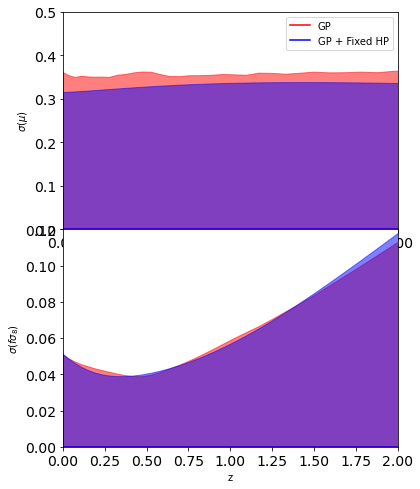

In [64]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  np.zeros_like(dXi_HXi_m), color ='r', label='GP')
plt.fill_between(z_arr, dXi_HXi_s,
                 -dXi_HXi_s, color='r', alpha=.5)

plt.plot(z_arr,  np.zeros_like(dXi_HXi_hp_m), color ='b', label='GP + Fixed HP')
plt.fill_between(z_arr, dXi_HXi_hp_s,
                 -dXi_HXi_hp_s, color='b', alpha=.5)

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.5)
plt.xlabel("z")
plt.ylabel(r"$ \sigma( \mu)$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  np.zeros_like(dfs8_HXi_m), color ='r', label='GP')
plt.fill_between(z_arr, dfs8_HXi_s,
                 -dfs8_HXi_s, color='r', alpha=.5)

plt.plot(z_arr,  np.zeros_like(dfs8_HXi_hp_m), color ='b', label='GP + Fixed HP')
plt.fill_between(z_arr, dfs8_HXi_hp_s,
                 -dfs8_HXi_s, color='b', alpha=.5)

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.12)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(f\sigma_8)$")
#plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

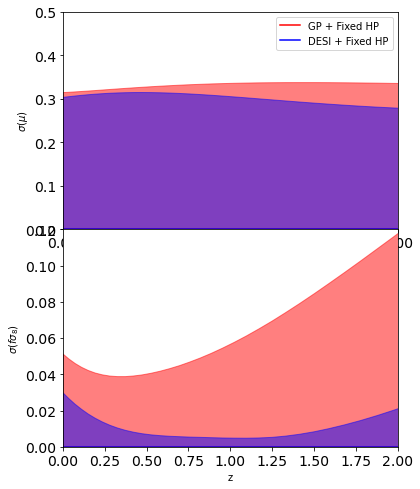

In [65]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  np.zeros_like(dXi_HXi_hp_m), color ='r', label='GP + Fixed HP')
plt.fill_between(z_arr, dXi_HXi_hp_s,
                 -dXi_HXi_hp_s, color='r', alpha=.5)

plt.plot(z_arr,  np.zeros_like(dXi_DESI_HXi_hp_m), color ='b', label='DESI + Fixed HP')
plt.fill_between(z_arr, dXi_DESI_HXi_hp_s,
                 -dXi_DESI_HXi_hp_s, color='b', alpha=.5)


#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.5)
plt.xlabel("z")
plt.ylabel(r"$ \sigma( \mu)$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  np.zeros_like(dfs8_HXi_hp_m), color ='r', label='GP + Fixed HP')
plt.fill_between(z_arr, dfs8_HXi_hp_s,
                 -dfs8_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dfs8_DESI_HXi_hp_m), color ='b', label='DESI + Fixed HP')
plt.fill_between(z_arr, dfs8_DESI_HXi_hp_s,
                 -dfs8_DESI_HXi_s, color='b', alpha=.5)

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.12)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(f\sigma_8)$")
#plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

/tmp/ipykernel_934/1600658886.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)
/tmp/ipykernel_934/1600658886.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


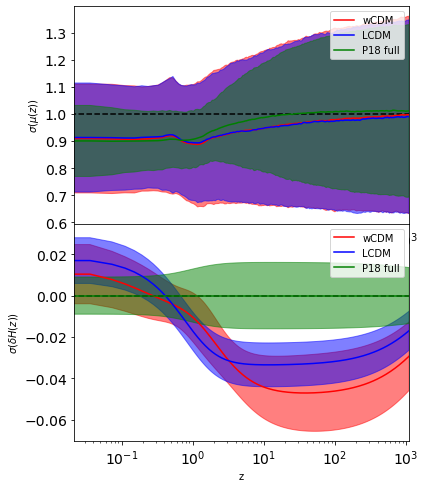

In [109]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  np.ones_like(z_arr), 'k--')

#plt.plot(z_arr,  dXi_HXi_n_m, color ='g', label='GP')
#plt.fill_between(z_arr, dXi_HXi_n_m+dXi_HXi_n_s,
#                 dXi_HXi_n_m-dXi_HXi_n_s, color='g', alpha=.5)

plt.plot(z_arr,  dXi_Xi_wCDM_m, color ='r', label='wCDM')
plt.fill_between(z_arr,  dXi_Xi_wCDM_m+dXi_Xi_wCDM_s,
                  dXi_Xi_wCDM_m-dXi_Xi_wCDM_s, color='r', alpha=.5)

plt.plot(z_arr, dXi_Xi_LCDM_m, color ='b', label='LCDM')
plt.fill_between(z_arr, dXi_Xi_LCDM_m+dXi_Xi_LCDM_s,
                 dXi_Xi_LCDM_m-dXi_Xi_LCDM_s, color='b', alpha=.5)

plt.plot(z_arr, dXi_Xi_P18_full_m, color ='g', label='P18 full')
plt.fill_between(z_arr, dXi_Xi_P18_full_m+dXi_Xi_P18_full_s,
                 dXi_Xi_P18_full_m-dXi_Xi_P18_full_s, color='g', alpha=.5)

#plt.plot(z_planck, np.ones_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
#plt.ylim(0., 0.1)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(\mu(z))$")
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  np.zeros_like(z_arr), 'k--')
plt.plot(z_arr,  dH_Xi_wCDM_m, color ='r', label='wCDM')
plt.fill_between(z_arr,  dH_Xi_wCDM_m+dH_Xi_wCDM_s,
                  dH_Xi_wCDM_m-dH_Xi_wCDM_s, color='r', alpha=.5)
plt.plot(z_arr, dH_Xi_LCDM_m, color ='b', label='LCDM')
plt.fill_between(z_arr, dH_Xi_LCDM_m+dH_Xi_LCDM_s,
                 dH_Xi_LCDM_m-dH_Xi_LCDM_s, color='b', alpha=.5)
plt.plot(z_arr, dH_Xi_P18_full_m, color ='g', label='P18 full')
plt.fill_between(z_arr, dH_Xi_P18_full_m+dH_Xi_P18_full_s,
                 dH_Xi_P18_full_m-dH_Xi_P18_full_s, color='g', alpha=.5)

plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1100)
#plt.ylim(0., 0.1)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(\delta H(z))$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);


/tmp/ipykernel_1524/2907326410.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 2)
/tmp/ipykernel_1524/2907326410.py:34: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 2)


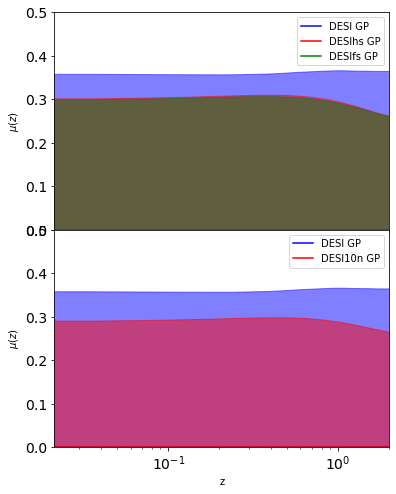

In [59]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  np.zeros_like(dXi_DESI_HXi_m), color ='b', label='DESI GP')
plt.fill_between(z_arr, dXi_DESI_HXi_s,
                 -dXi_DESI_HXi_s, color='b', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dXi_DESIts_HXi_m), color ='r', label='DESIts GP')
plt.fill_between(z_arr, dXi_DESIts_HXi_s,
                 -dXi_DESIts_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dXi_DESIhs_HXi_m), color ='r', label='DESIhs GP')
plt.fill_between(z_arr, dXi_DESIhs_HXi_s,
                 -dXi_DESIhs_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dXi_DESIfs_HXi_m), color ='g', label='DESIfs GP')
plt.fill_between(z_arr, dXi_DESIfs_HXi_s,
                 -dXi_DESIfs_HXi_s, color='g', alpha=.5)
plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0, 0.5)
plt.xlabel("z")
plt.ylabel(r"$ \mu(z)$")
plt.legend();
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  np.zeros_like(dXi_DESI_HXi_m), color ='b', label='DESI GP')
plt.fill_between(z_arr, dXi_DESI_HXi_s,
                 -dXi_DESI_HXi_s, color='b', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dXi_DESI10n_HXi_m), color ='r', label='DESI10n GP')
plt.fill_between(z_arr, dXi_DESI10n_HXi_s,
                 -dXi_DESI10n_HXi_s, color='r', alpha=.5)

plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0, 0.5)
plt.xlabel("z")
plt.ylabel(r"$ \mu(z)$")
plt.legend();


plt.xticks(fontsize=14)
plt.yticks(fontsize=14);


# d_H gp 

In [ ]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  np.zeros_like(dHgp_HXi_m), color ='r', label='GP')
plt.fill_between(z_arr, dHgp_HXi_s,
                 -dHgp_HXi_s, color='r', alpha=.5)

plt.plot(z_arr,  np.zeros_like(dHgp_HXi_hp_m), color ='b', label='GP + Fixed HP')
plt.fill_between(z_arr, dHgp_HXi_hp_s,
                 -dHgp_HXi_hp_s, color='b', alpha=.5)


#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.15)
plt.xlabel("z")
plt.ylabel(r"$ \sigma (\delta H_{gp})$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  np.zeros_like(dH_HXi_m), color ='r', label='GP')
plt.fill_between(z_arr, dH_HXi_s,
                 -dH_HXi_s, color='r', alpha=.5)

plt.plot(z_arr,  np.zeros_like(dH_HXi_hp_m), color ='b', label='GP + Fixed HP')
plt.fill_between(z_arr, dH_HXi_hp_s,
                 -dH_HXi_s, color='b', alpha=.5)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.03)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(H) $")
#plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

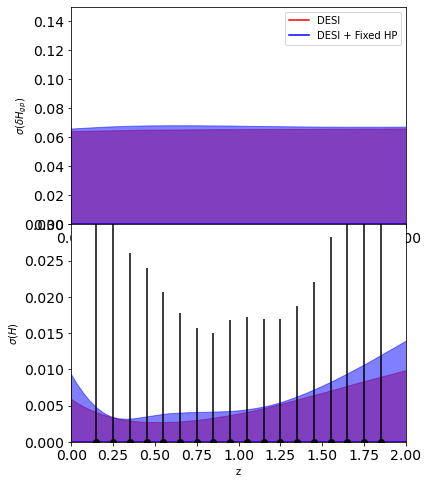

In [48]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  np.zeros_like(dHgp_DESI_HXi_m), color ='r', label='DESI')
plt.fill_between(z_arr, dHgp_DESI_HXi_s,
                 -dHgp_DESI_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dHgp_DESI_HXi_hp_m), color ='b', label='DESI + Fixed HP')
plt.fill_between(z_arr, dHgp_DESI_HXi_hp_s,
                 -dHgp_DESI_HXi_hp_s, color='b', alpha=.5)

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.15)
plt.xlabel("z")
plt.ylabel(r"$ \sigma (\delta H_{gp})$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
ax1 = plt.subplot(212)
plt.plot(z_arr,  np.zeros_like(dH_DESI_HXi_m), color ='r', label='DESI')
plt.fill_between(z_arr, dH_DESI_HXi_s,
                 -dH_DESI_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dH_DESI_HXi_hp_m), color ='b', label='DESI + Fixed HP')
plt.fill_between(z_arr, dH_DESI_HXi_hp_s,
                 -dH_DESI_HXi_s, color='b', alpha=.5)
plt.errorbar(DESI_data['z'], np.zeros_like(DESI_data['H_data']-Hmean)/Hmean,
             yerr = DESI_data['H_err']/Hmean, fmt='ko', label='DESI')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.03)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(H) $")
#plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

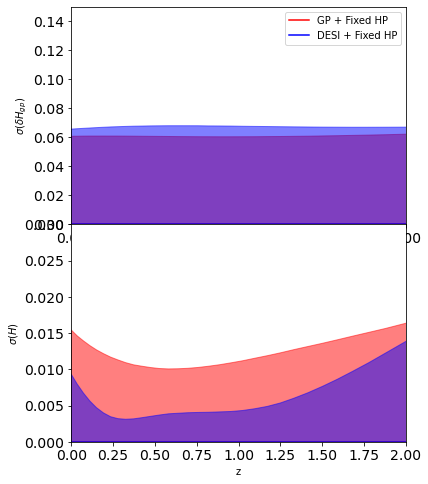

In [49]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  np.zeros_like(dHgp_HXi_hp_m), color ='r', label='GP + Fixed HP')
plt.fill_between(z_arr, dHgp_HXi_hp_s,
                 -dHgp_HXi_hp_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dHgp_DESI_HXi_hp_m), color ='b', label='DESI + Fixed HP')
plt.fill_between(z_arr, dHgp_DESI_HXi_hp_s,
                 -dHgp_DESI_HXi_hp_s, color='b', alpha=.5)

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.15)
plt.xlabel("z")
plt.ylabel(r"$ \sigma (\delta H_{gp})$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  np.zeros_like(dH_HXi_hp_m), color ='r', label='GP + Fixed HP')
plt.fill_between(z_arr, dH_HXi_hp_s,
                 -dH_HXi_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dH_DESI_HXi_hp_m), color ='b', label='DESI + Fixed HP')
plt.fill_between(z_arr, dH_DESI_HXi_hp_s,
                 -dH_DESI_HXi_s, color='b', alpha=.5)
#plt.errorbar(DESI_data['z'], np.zeros_like(DESI_data['H_data']-Hmean)/Hmean,
#             yerr = DESI_data['H_err']/Hmean, fmt='ko', label='DESI')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.03)
plt.xlabel("z")
plt.ylabel(r"$ \sigma(H) $")
#plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

/tmp/ipykernel_934/39990121.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 2)
/tmp/ipykernel_934/39990121.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0., 0.02)


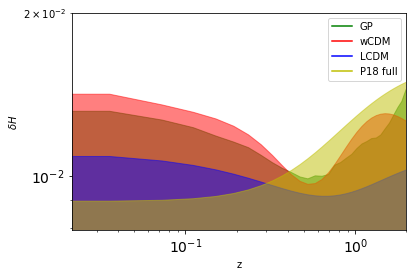

In [50]:
plt.plot(z_arr,  np.zeros_like(dH_HXi_m), color ='g', label='GP')
plt.fill_between(z_arr, dH_HXi_s,
                 -dH_HXi_s, color='g', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dH_Xi_wCDM_m), color ='r', label='wCDM')
plt.fill_between(z_arr, dH_Xi_wCDM_s,
                 -dH_Xi_wCDM_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dH_Xi_LCDM_m), color ='b', label='LCDM')
plt.fill_between(z_arr, dH_Xi_LCDM_s,
                 -dH_Xi_LCDM_s, color='b', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dH_Xi_P18_m), color ='y', label='P18 full')
plt.fill_between(z_arr, dH_Xi_P18_s,
                 -dH_Xi_P18_s, color='y', alpha=.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0., 0.02)
plt.xlabel("z")
plt.ylabel(r"$ \delta H$")
plt.legend();
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);


/tmp/ipykernel_934/991985479.py:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 2)
/tmp/ipykernel_934/991985479.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 0.075)
/tmp/ipykernel_934/991985479.py:43: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 2)
/tmp/ipykernel_934/991985479.py:44: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 0.075)


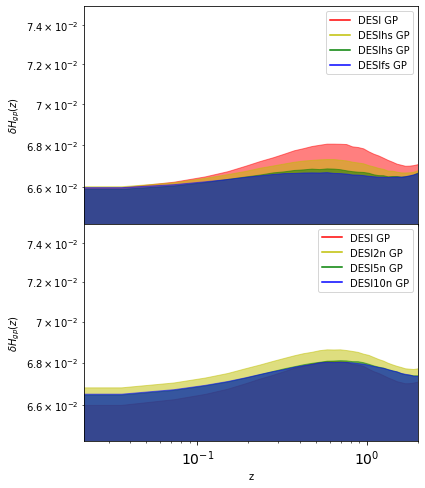

In [67]:
fig=plt.figure(figsize=(6,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
plt.plot(z_arr,  np.zeros_like(dHgp_DESI_HXi_hp_m), color ='r', label='DESI GP')
plt.fill_between(z_arr, dHgp_DESI_HXi_hp_s,
                 -dHgp_DESI_HXi_hp_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dHgp_DESIts_HXi_m), color ='y', label='DESIhs GP')
plt.fill_between(z_arr, dHgp_DESIts_HXi_s,
                 -dHgp_DESIts_HXi_s, color='y', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dHgp_DESIhs_HXi_m), color ='g', label='DESIhs GP')
plt.fill_between(z_arr, dHgp_DESIhs_HXi_s,
                 -dHgp_DESIhs_HXi_s, color='g', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dHgp_DESIfs_HXi_m), color ='b', label='DESIfs GP')
plt.fill_between(z_arr, dHgp_DESIfs_HXi_s,
                 -dHgp_DESIfs_HXi_s, color='b', alpha=.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0, 0.075)
plt.xlabel("z")
plt.ylabel(r"$ \delta H_{gp}(z)$")
plt.legend();

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

ax1 = plt.subplot(212)
plt.plot(z_arr,  np.zeros_like(dHgp_DESI_HXi_hp_m), color ='r', label='DESI GP')
plt.fill_between(z_arr, dHgp_DESI_HXi_hp_s,
                 -dHgp_DESI_HXi_hp_s, color='r', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dHgp_DESI2n_HXi_m), color ='y', label='DESI2n GP')
plt.fill_between(z_arr, dHgp_DESI2n_HXi_s,
                 -dHgp_DESI2n_HXi_s, color='y', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dHgp_DESI5n_HXi_m), color ='g', label='DESI5n GP')
plt.fill_between(z_arr, dHgp_DESI5n_HXi_s,
                 -dHgp_DESI5n_HXi_s, color='g', alpha=.5)
plt.plot(z_arr,  np.zeros_like(dHgp_DESI10n_HXi_m), color ='b', label='DESI10n GP')
plt.fill_between(z_arr, dHgp_DESI10n_HXi_s,
                 -dHgp_DESI10n_HXi_s, color='b', alpha=.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 2)
plt.ylim(0, 0.075)
plt.xlabel("z")
plt.ylabel(r"$ \delta H_{gp}(z)$")
plt.legend();
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);


# $\sigma_\mu$ - $\sigma_H$ Plots

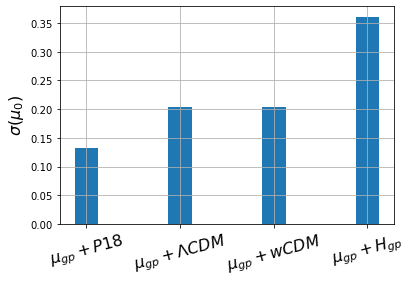

In [52]:
files = [Xi_P18_full, Xi_LCDM, Xi_wCDM, HXi]
labels =  ['$\mu_{gp}+P18$', '$\mu_{gp}+\Lambda CDM$', '$\mu_{gp}+wCDM$', '$\mu_{gp}+H_{gp}$']
sig_sigs = [np.std(np.transpose(file['Xiz']),1)[0] for file in files]
x = [2*i for i in np.arange(len(files))]
plt.grid()
plt.bar(x, sig_sigs, 0.5)
#plt.scatter(x, sig_sigs,color='k')
plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\sigma(\mu_0)$', fontsize=16)
#plt.ylim(0.075, 0.2)

plt.show()

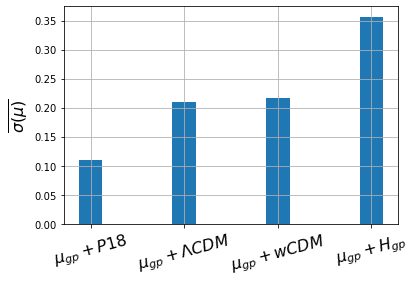

In [53]:
files = [Xi_P18_full, Xi_LCDM, Xi_wCDM, HXi]
labels =  ['$\mu_{gp}+P18$', '$\mu_{gp}+\Lambda CDM$', '$\mu_{gp}+wCDM$', '$\mu_{gp}+H_{gp}$']
sig_sigs = [np.mean(np.std(np.transpose(file['Xiz']),1)[:33]) for file in files]
x = [2*i for i in np.arange(len(files))]
plt.grid()
plt.bar(x, sig_sigs, 0.5)
#plt.scatter(x, sig_sigs,color='k')
plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\overline{\sigma(\mu)}$', fontsize=16)
#plt.ylim(0.075, 0.2)

plt.show()

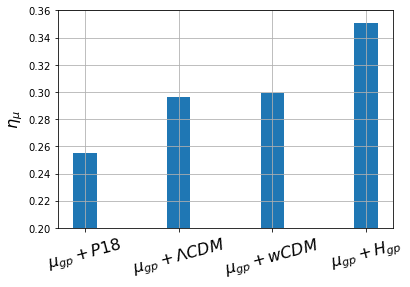

In [54]:
files = [Xi_P18_full, Xi_LCDM, Xi_wCDM, HXi]
labels =  ['$\mu_{gp}+P18$', '$\mu_{gp}+\Lambda CDM$', '$\mu_{gp}+wCDM$', '$\mu_{gp}+H_{gp}$']
sig_sigs = [np.mean(file['n_Xi']) for file in files]
x = [2*i for i in np.arange(len(files))]
plt.grid()
plt.bar(x, sig_sigs, 0.5)
#plt.scatter(x, sig_sigs,color='k')
plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\eta_\mu$', fontsize=16)
plt.ylim(0.2, 0.36)

plt.show()

In [55]:
files = [DESI100n_HXi, DESI10n_HXi, DESIfs_HXi, DESIhs_HXi, DESI_HXi]
labels =  ['DESI_100n', 'DESI_10n', 'DESI_fs', 'DESI_hs', 'DESI']
sig_sigs = [np.std(np.transpose(file['Xiz']),1)[0] for file in files]
x = [2*i for i in np.arange(len(files))]
plt.grid()
plt.bar(x, sig_sigs, 0.5)
#plt.scatter(x, sig_sigs,color='k')
plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\sigma(\mu_0)$', fontsize=16)
plt.ylim(0.2, 0.38)
plt.show()

NameError: name 'DESI100n_HXi' is not defined

In [56]:
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0)
files = [DESI100n_HXi, DESI10n_HXi, DESIfs_HXi, DESIhs_HXi, DESI_HXi]
labels =  ['DESI_100n', 'DESI_10n', 'DESI_fs', 'DESI_hs', 'DESI']

ax1 = plt.subplot(211)
sigs = [np.mean(np.std(np.transpose(file['DHz']),1)[:33]) for file in files]
x = [2*i for i in np.arange(len(files))]
plt.grid()
plt.bar(x, sigs, 0.5)
#plt.scatter(x, sig_sigs,color='k')
#plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\overline{\sigma(\delta H)}$', fontsize=16)
plt.ylim(0.04, 0.072)

ax2 = plt.subplot(212, sharex = ax1)
sigs = [np.mean(np.std(np.transpose(file['Xiz']),1)[:33]) for file in files]
x = [2*i for i in np.arange(len(files))]
plt.grid()
plt.bar(x, sigs, 0.5)
#plt.scatter(x, sig_sigs,color='k')
plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\overline{\sigma(\mu)}$', fontsize=16)
plt.ylim(0.2, 0.38)

plt.show()

NameError: name 'DESI100n_HXi' is not defined

<Figure size 576x576 with 0 Axes>

In [57]:
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0)
files = [DESI100n_HXi, DESI10n_HXi, DESIfs_HXi, DESIhs_HXi, DESI_HXi]
labels =  ['DESI_100n', 'DESI_10n', 'DESI_fs', 'DESI_hs', 'DESI']

ax1 = plt.subplot(211)
sigs = [np.mean(file['n_H']) for file in files]
x = [2*i for i in np.arange(len(files))]
plt.grid()
plt.bar(x, sigs, 0.6)
#plt.scatter(x, sig_sigs,color='k')
#plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\eta_H$', fontsize=16)
plt.ylim(0.04, 0.072)

ax2 = plt.subplot(212, sharex = ax1)
sigs = [np.mean(file['n_Xi']) for file in files]
x = [2*i for i in np.arange(len(files))]
plt.grid()
plt.bar(x, sigs, 0.5)
#plt.scatter(x, sig_sigs,color='k')
plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\eta_\mu$', fontsize=16)
plt.ylim(0.2, 0.39)

plt.show()

NameError: name 'DESI100n_HXi' is not defined

<Figure size 576x576 with 0 Axes>

NameError: name 'dH_DESI100n_HXi_s' is not defined

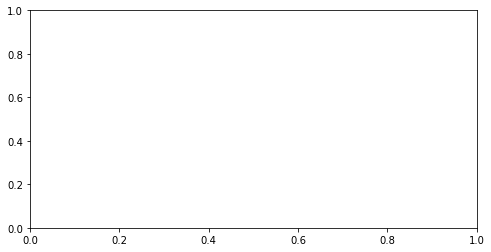

In [58]:
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
sigs = [min(dH_DESI100n_HXi_s), min(dH_DESI10n_HXi_s), min(dH_DESIfs_HXi_s), min(dH_DESIhs_HXi_s), min(dH_DESI_HXi_s)]
sigs2 = [min(dH_DESI100n_LCDM_s), min(dH_DESI10n_LCDM_s), min(dH_DESIfs_LCDM_s), min(dH_DESIhs_LCDM_s), min(dH_DESI_LCDM_s)]
labels = ['DESI_100n', 'DESI_10n', 'DESI_fs', 'DESI_hs', 'DESI']
x = [2*i for i in np.arange(len(sigs))]
plt.grid()
plt.bar(x, sigs, 0.5, label="GPs")
plt.bar(x, sigs2, 0.5, label="LCDM")
#plt.scatter(x, sig_sigs,color='k')
#plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$ \sigma (H^*)$', fontsize=16)
plt.legend()

ax2 = plt.subplot(212, sharex = ax1)
sigs = [min(dfs8_DESI100n_HXi_s), min(dfs8_DESI10n_HXi_s), min(dfs8_DESIfs_HXi_s),
        min(dfs8_DESIhs_HXi_s), min(dfs8_DESI_HXi_s)]
sigs2 = [min(dfs8_DESI100n_LCDM_s), min(dfs8_DESI10n_LCDM_s), min(dfs8_DESIfs_LCDM_s),
         min(dfs8_DESIhs_LCDM_s), min(dfs8_DESI_LCDM_s)]
labels = ['DESI_100n', 'DESI_10n', 'DESI_fs', 'DESI_hs', 'DESI']
x = [2*i for i in np.arange(len(sigs))]
plt.grid()
plt.bar(x, sigs, 0.5, label="GPs")
plt.bar(x, sigs2, 0.5, label="LCDM")
plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$ \sigma (f \sigma_8^*)$', fontsize=16)
plt.legend()
plt.show()

NameError: name 'dH_DESI100n_HXi_s' is not defined

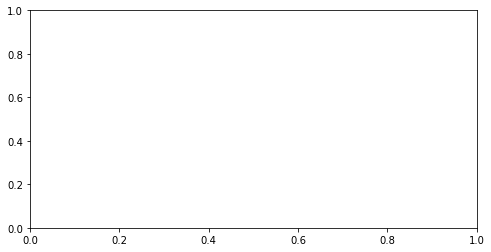

In [59]:
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(211)
sigs = [min(dH_DESI100n_HXi_s), min(dH_DESI10n_HXi_s), min(dH_DESIfs_HXi_s), min(dH_DESIhs_HXi_s), min(dH_DESI_HXi_s)]
sigs2 = [min(dH_DESI100n_LCDM_s), min(dH_DESI10n_LCDM_s), min(dH_DESIfs_LCDM_s), min(dH_DESIhs_LCDM_s), min(dH_DESI_LCDM_s)]
ratio = [sigs[i]/sigs2[i] for i in np.arange(len(sigs))]
labels = ['DESI_100n', 'DESI_10n', 'DESI_fs', 'DESI_hs', 'DESI']
x = [2*i for i in np.arange(len(sigs))]
plt.grid()
plt.bar(x, ratio, 0.5)
#plt.scatter(x, sig_sigs,color='k')
#plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\sigma_H^{GP}/ \sigma_H^{LCDM}$', fontsize=16)
#plt.ylim(0.025, 0.05)

ax2 = plt.subplot(212, sharex = ax1)
sigs = [min(dfs8_DESI100n_HXi_s), min(dfs8_DESI10n_HXi_s), min(dfs8_DESIfs_HXi_s),
        min(dfs8_DESIhs_HXi_s), min(dfs8_DESI_HXi_s)]
sigs2 = [min(dfs8_DESI100n_LCDM_s), min(dfs8_DESI10n_LCDM_s), min(dfs8_DESIfs_LCDM_s),
         min(dfs8_DESIhs_LCDM_s), min(dfs8_DESI_LCDM_s)]
ratio = [sigs[i]/sigs2[i] for i in np.arange(len(sigs))]
labels = ['DESI_100n', 'DESI_10n', 'DESI_fs', 'DESI_hs', 'DESI']
x = [2*i for i in np.arange(len(sigs))]
plt.grid()
plt.bar(x, ratio, 0.5)
#plt.scatter(x, sig_sigs,color='k')
plt.xticks(x, labels, fontsize=16)
plt.xticks(rotation=15)
plt.ylabel('$\sigma_{f \sigma_8}^{GP} / \sigma_{f \sigma_8}^{LCDM}$', fontsize=16)
#plt.ylim(0.025, 0.05)
plt.show()